In [1]:
import pylab as pl
from glob import glob
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import csv
import os
import datetime
import pandas as pd
import shapefile as shp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker
import netCDF4 as nc4
from datetime import date,timedelta
import plotly.graph_objs as go
import matplotlib.lines as mlines
import seaborn as sns
import shapely as shp
from shapely.geometry import Point
import importlib
import geopandas as gpd
from matplotlib.patches import Rectangle
from collections import Counter
import time
import _pickle as pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable

#import external functions (need pip install ipynb)
import ipynb.fs.full.HaileventsFunctions as HF

# 2) - OT FILTERING

**Structure of the filter:**

- Read OT data, hourly aggregate, spatial domain over SPHERA, parallax correction, write them in xarray and then to geodataframe
- **Temporal window**: from ot timing extract the last **3h** of SPHERA proxies and aggregate them to 1 geodataframe (extracting max/min values over the 3 temporal steps) 
- **Spatial window**: consider a neighbourhood of 7x7 (upscaled) SPHERA grid cells (circa 70km) around the OT detection
- **Threshold values**: defined as 5-95 percentiles of the SPHERA paramters distribution in presence of ESWD reports (with the same spatio-temporal window criterion for the filter and extracting max/min parameters in the neighborhood)
- **Filtering OTs**: apply the procedure to every OT of the considered hourly dataset and filter out irrelevant OTs, then compare before and after

## 2.0) - Preamble: load data folder, shapefiles, lat-lon domain, define SPHERA thresholds, define days of interest

In [2]:
#Define preliminar parameters: files folder, shapefiles, lat-lon domain
fold, sf_geo, sfg_land, sf_sp, lonmin, lonmax, latmin, latmax, x_lim, y_lim, hhmin, hhmax = HF.HF_preamble()

In [3]:
#Define SPHERA parameters thresholds
t_CAPE = 666.16 #618.42
t_K = 32.5
t_LI = -2.16 #-2.08
t_DLS = 7.56 #9.25
t_H0 = 4098 #4039

#### 2.0.1) - Identify missing/problematic data

**- Missing OT data/wrong names**

  **- 2016**

    - (0) 2016092 SPHERA data devono esere trattati separatamente e mancano OTs fino alle 0600
    - (1) 2016093 SPHERA data devono essere trattati separatamente
    - (41) 2016133 OT mancanti fino alle 2115
    - (93) 2016185 2016-07-03 -> SPHERA data mancanti tutto il giorno (from 01 to 23) (32 OTs, no eswd reports)
    - (94) 2016186 2016-07-04 -> SPHERA data mancanti solo alle 0000 (no Ots, no eswd reports)
    - (109) 2016201 2016-07-19 -> SPHERA data mancanti dalle 11 alle 23 (SKIP DAY)
    - (198) 2016290 (MET09 invece di MET10)
    - (199) 2016291 OT data mancanti fino alle 1300
    
  **- 2017**
  
    - (18) 2017110 (MET08 invece di MET10)
    - (19) 2017111 OT data mancanti fino alle 1545
    - (147) 2017239 (MET08 invece di MET10) -> RISOLTO (rinominati file da 08 a 10)
    
  **- 2018**
  
    - (35) 2018127 (MET09 invece di MET11)
    - (36) 2018128 OT data mancanti fino alle 0900
    - (76) 2018168 (17-6-2018): missing OT data whole day (but no eswd reports and 6 unipol reports)
    - (100) 2018192 OT mancanti fino alle 0815
    - (128) 2018220 OT mancanti fino alle 0015
    
**- 2019**

**- 2020**

    - (0) 2020092  OT mancanti tutto il giorno -> skip day
  

In [4]:
#DEFINE LIST OF DAYS WITH JULIAN DAY AND DATETIME FORMAT:

#days in 2016: 214 days (actually 211 because the following days are missing: 2016185,2016186,2016201 )
days_2016 = [2016092,2016093,2016094,2016095,2016096,2016097,2016098,2016099,2016100,2016101,2016102,2016103,2016104,
        2016105,2016106,2016107,2016108,2016109,2016110,2016111,2016112,2016113,2016114,2016115,2016116,2016117,
        2016118,2016119,2016120,2016121,2016122,2016123,2016124,2016125,2016126,2016127,2016128,2016129,2016130,
        2016131,2016132,2016133,2016134,2016135,2016136,2016137,2016138,2016139,2016140,2016141,2016142,2016143,
        2016144,2016145,2016146,2016147,2016148,2016149,2016150,2016151,2016152,2016153,2016154,2016155,2016156,
        2016157,2016158,2016159,2016160,2016161,2016162,2016163,2016164,2016165,2016166,2016167,2016168,2016169,
        2016170,2016171,2016172,2016173,2016174,2016175,2016176,2016177,2016178,2016179,2016180,2016181,2016182,
        2016183,2016184,2016185,2016186,2016187,2016188,2016189,2016190,2016191,2016192,2016193,2016194,2016195,
        2016196,2016197,2016198,2016199,2016200,2016201,2016202,2016203,2016204,2016205,2016206,2016207,2016208,
        2016209,2016210,2016211,2016212,2016213,2016214,2016215,2016216,2016217,2016218,2016219,2016220,2016221,
        2016222,2016223,2016224,2016225,2016226,2016227,2016228,2016229,2016230,2016231,2016232,2016233,2016234,
        2016235,2016236,2016237,2016238,2016239,2016240,2016241,2016242,2016243,2016244,2016245,2016246,2016247,
        2016248,2016249,2016250,2016251,2016252,2016253,2016254,2016255,2016256,2016257,2016258,2016259,2016260,
        2016261,2016262,2016263,2016264,2016265,2016266,2016267,2016268,2016269,2016270,2016271,2016272,2016273,
        2016274,2016275,2016276,2016277,2016278,2016279,2016280,2016281,2016282,2016283,2016284,2016285,2016286,
        2016287,2016288,2016289,2016290,2016291,2016292,2016293,2016294,2016295,2016296,2016297,2016298,2016299,
        2016300,2016301,2016302,2016303,2016304,2016305]

#days in 2017: missing 1 april (2017091), 213 days
days_2017 = [2017091,2017092,2017093,2017094,2017095,2017096,2017097,2017098,2017099,2017100,2017101,2017102,2017103,2017104,
        2017105,2017106,2017107,2017108,2017109,2017110,2017111,2017112,2017113,2017114,2017115,2017116,2017117,
        2017118,2017119,2017120,2017121,2017122,2017123,2017124,2017125,2017126,2017127,2017128,2017129,2017130,
        2017131,2017132,2017133,2017134,2017135,2017136,2017137,2017138,2017139,2017140,2017141,2017142,2017143,
        2017144,2017145,2017146,2017147,2017148,2017149,2017150,2017151,2017152,2017153,2017154,2017155,2017156,
        2017157,2017158,2017159,2017160,2017161,2017162,2017163,2017164,2017165,2017166,2017167,2017168,2017169,
        2017170,2017171,2017172,2017173,2017174,2017175,2017176,2017177,2017178,2017179,2017180,2017181,2017182,
        2017183,2017184,2017185,2017186,2017187,2017188,2017189,2017190,2017191,2017192,2017193,2017194,2017195,
        2017196,2017197,2017198,2017199,2017200,2017201,2017202,2017203,2017204,2017205,2017206,2017207,2017208,
        2017209,2017210,2017211,2017212,2017213,2017214,2017215,2017216,2017217,2017218,2017219,2017220,2017221,
        2017222,2017223,2017224,2017225,2017226,2017227,2017228,2017229,2017230,2017231,2017232,2017233,2017234,
        2017235,2017236,2017237,2017238,2017239,2017240,2017241,2017242,2017243,2017244,2017245,2017246,2017247,
        2017248,2017249,2017250,2017251,2017252,2017253,2017254,2017255,2017256,2017257,2017258,2017259,2017260,
        2017261,2017262,2017263,2017264,2017265,2017266,2017267,2017268,2017269,2017270,2017271,2017272,2017273,
        2017274,2017275,2017276,2017277,2017278,2017279,2017280,2017281,2017282,2017283,2017284,2017285,2017286,
        2017287,2017288,2017289,2017290,2017291,2017292,2017293,2017294,2017295,2017296,2017297,2017298,2017299,
        2017300,2017301,2017302,2017303,2017304]

#days in 2018: missing 1 april (2018091) and 17 june (2018168), 212 days
days_2018 = [2018091,2018092,2018093,2018094,2018095,2018096,2018097,2018098,2018099,2018100,2018101,2018102,2018103,2018104,
        2018105,2018106,2018107,2018108,2018109,2018110,2018111,2018112,2018113,2018114,2018115,2018116,2018117,
        2018118,2018119,2018120,2018121,2018122,2018123,2018124,2018125,2018126,2018127,2018128,2018129,2018130,
        2018131,2018132,2018133,2018134,2018135,2018136,2018137,2018138,2018139,2018140,2018141,2018142,2018143,
        2018144,2018145,2018146,2018147,2018148,2018149,2018150,2018151,2018152,2018153,2018154,2018155,2018156,
        2018157,2018158,2018159,2018160,2018161,2018162,2018163,2018164,2018165,2018166,2018167,2018168,2018169,
        2018170,2018171,2018172,2018173,2018174,2018175,2018176,2018177,2018178,2018179,2018180,2018181,2018182,
        2018183,2018184,2018185,2018186,2018187,2018188,2018189,2018190,2018191,2018192,2018193,2018194,2018195,
        2018196,2018197,2018198,2018199,2018200,2018201,2018202,2018203,2018204,2018205,2018206,2018207,2018208,
        2018209,2018210,2018211,2018212,2018213,2018214,2018215,2018216,2018217,2018218,2018219,2018220,2018221,
        2018222,2018223,2018224,2018225,2018226,2018227,2018228,2018229,2018230,2018231,2018232,2018233,2018234,
        2018235,2018236,2018237,2018238,2018239,2018240,2018241,2018242,2018243,2018244,2018245,2018246,2018247,
        2018248,2018249,2018250,2018251,2018252,2018253,2018254,2018255,2018256,2018257,2018258,2018259,2018260,
        2018261,2018262,2018263,2018264,2018265,2018266,2018267,2018268,2018269,2018270,2018271,2018272,2018273,
        2018274,2018275,2018276,2018277,2018278,2018279,2018280,2018281,2018282,2018283,2018284,2018285,2018286,
        2018287,2018288,2018289,2018290,2018291,2018292,2018293,2018294,2018295,2018296,2018297,2018298,2018299,
        2018300,2018301,2018302,2018303,2018304]

days_2019 = [2019091,2019092,2019093,2019094,2019095,2019096,2019097,2019098,2019099,2019100,2019101,2019102,2019103,2019104,
        2019105,2019106,2019107,2019108,2019109,2019110,2019111,2019112,2019113,2019114,2019115,2019116,2019117,
        2019118,2019119,2019120,2019121,2019122,2019123,2019124,2019125,2019126,2019127,2019128,2019129,2019130,
        2019131,2019132,2019133,2019134,2019135,2019136,2019137,2019138,2019139,2019140,2019141,2019142,2019143,
        2019144,2019145,2019146,2019147,2019148,2019149,2019150,2019151,2019152,2019153,2019154,2019155,2019156,
        2019157,2019158,2019159,2019160,2019161,2019162,2019163,2019164,2019165,2019166,2019167,2019168,2019169,
        2019170,2019171,2019172,2019173,2019174,2019175,2019176,2019177,2019178,2019179,2019180,2019181,2019182,
        2019183,2019184,2019185,2019186,2019187,2019188,2019189,2019190,2019191,2019192,2019193,2019194,2019195,
        2019196,2019197,2019198,2019199,2019200,2019201,2019202,2019203,2019204,2019205,2019206,2019207,2019208,
        2019209,2019210,2019211,2019212,2019213,2019214,2019215,2019216,2019217,2019218,2019219,2019220,2019221,
        2019222,2019223,2019224,2019225,2019226,2019227,2019228,2019229,2019230,2019231,2019232,2019233,2019234,
        2019235,2019236,2019237,2019238,2019239,2019240,2019241,2019242,2019243,2019244,2019245,2019246,2019247,
        2019248,2019249,2019250,2019251,2019252,2019253,2019254,2019255,2019256,2019257,2019258,2019259,2019260,
        2019261,2019262,2019263,2019264,2019265,2019266,2019267,2019268,2019269,2019270,2019271,2019272,2019273,
        2019274,2019275,2019276,2019277,2019278,2019279,2019280,2019281,2019282,2019283,2019284,2019285,2019286,
        2019287,2019288,2019289,2019290,2019291,2019292,2019293,2019294,2019295,2019296,2019297,2019298,2019299,
        2019300,2019301,2019302,2019303,2019304]

days_2020 = [2020092,2020093,2020094,2020095,2020096,2020097,2020098,2020099,2020100,2020101,2020102,2020103,2020104,
        2020105,2020106,2020107,2020108,2020109,2020110,2020111,2020112,2020113,2020114,2020115,2020116,2020117,
        2020118,2020119,2020120,2020121,2020122,2020123,2020124,2020125,2020126,2020127,2020128,2020129,2020130,
        2020131,2020132,2020133,2020134,2020135,2020136,2020137,2020138,2020139,2020140,2020141,2020142,2020143,
        2020144,2020145,2020146,2020147,2020148,2020149,2020150,2020151,2020152,2020153,2020154,2020155,2020156,
        2020157,2020158,2020159,2020160,2020161,2020162,2020163,2020164,2020165,2020166,2020167,2020168,2020169,
        2020170,2020171,2020172,2020173,2020174,2020175,2020176,2020177,2020178,2020179,2020180,2020181,2020182,
        2020183,2020184,2020185,2020186,2020187,2020188,2020189,2020190,2020191,2020192,2020193,2020194,2020195,
        2020196,2020197,2020198,2020199,2020200,2020201,2020202,2020203,2020204,2020205,2020206,2020207,2020208,
        2020209,2020210,2020211,2020212,2020213,2020214,2020215,2020216,2020217,2020218,2020219,2020220,2020221,
        2020222,2020223,2020224,2020225,2020226,2020227,2020228,2020229,2020230,2020231,2020232,2020233,2020234,
        2020235,2020236,2020237,2020238,2020239,2020240,2020241,2020242,2020243,2020244,2020245,2020246,2020247,
        2020248,2020249,2020250,2020251,2020252,2020253,2020254,2020255,2020256,2020257,2020258,2020259,2020260,
        2020261,2020262,2020263,2020264,2020265,2020266,2020267,2020268,2020269,2020270,2020271,2020272,2020273,
        2020274,2020275,2020276,2020277,2020278,2020279,2020280,2020281,2020282,2020283,2020284,2020285,2020286,
        2020287,2020288,2020289,2020290,2020291,2020292,2020293,2020294,2020295,2020296,2020297,2020298,2020299,
        2020300,2020301,2020302,2020303,2020304,2020305]

In [5]:
#write dataframes storing julian days and datetimes of OT days:

days_2016_df =pd.DataFrame(index=np.arange(0,len(days_2016),1), columns=['day','dtime'])
days_2017_df =pd.DataFrame(index=np.arange(0,len(days_2017),1), columns=['day','dtime'])
days_2018_df =pd.DataFrame(index=np.arange(0,len(days_2018),1), columns=['day','dtime'])
days_2019_df =pd.DataFrame(index=np.arange(0,len(days_2019),1), columns=['day','dtime'])
days_2020_df =pd.DataFrame(index=np.arange(0,len(days_2020),1), columns=['day','dtime'])

for day,ind in zip(days_2016,np.arange(0,len(days_2016),1)):
    
    dtime = datetime.datetime.strptime('2016-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2016_df.iloc[ind]['day'] = day
    days_2016_df.iloc[ind]['dtime'] = dtime    

for day,ind in zip(days_2017,np.arange(0,len(days_2017),1)):
    
    dtime = datetime.datetime.strptime('2017-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2017_df.iloc[ind]['day'] = day
    days_2017_df.iloc[ind]['dtime'] = dtime    
    
for day,ind in zip(days_2018,np.arange(0,len(days_2018),1)):
    
    dtime = datetime.datetime.strptime('2018-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2018_df.iloc[ind]['day'] = day
    days_2018_df.iloc[ind]['dtime'] = dtime
    
for day,ind in zip(days_2019,np.arange(0,len(days_2019),1)):
    
    dtime = datetime.datetime.strptime('2019-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2019_df.iloc[ind]['day'] = day
    days_2019_df.iloc[ind]['dtime'] = dtime   
    
for day,ind in zip(days_2020,np.arange(0,len(days_2020),1)):
    
    dtime = datetime.datetime.strptime('2020-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2020_df.iloc[ind]['day'] = day
    days_2020_df.iloc[ind]['dtime'] = dtime   

days_2016_df.dtime = pd.to_datetime(days_2016_df.dtime)
days_2017_df.dtime = pd.to_datetime(days_2017_df.dtime)
days_2018_df.dtime = pd.to_datetime(days_2018_df.dtime)
days_2019_df.dtime = pd.to_datetime(days_2019_df.dtime)
days_2020_df.dtime = pd.to_datetime(days_2020_df.dtime)


#REMOVE MISSING DAYS (after creating dataframes otherwise day and dtime are shifted and wrong!!!)

#-2016: 2016185,2016186,2016201
days_2016_df = days_2016_df[(days_2016_df.day !=2016185) & (days_2016_df.day !=2016186) & 
                            (days_2016_df.day !=2016201)]
#-2017: 2017091 
days_2017_df = days_2017_df[days_2017_df.day != 2017091]

#-2018: 2018091, 2018168
days_2018_df = days_2018_df[(days_2018_df.day != 2018091) & (days_2018_df.day != 2018168)]

#-2019:

#-2020:
days_2020_df = days_2020_df[days_2020_df.day != 2020092]

## 2.1) - OT filtering: consider every single parameter alone and the full filter, loop on several days

In [6]:
#Decide year to filter:
year=2018
days_df = days_2018_df

In [12]:
#Loop on days:
for d_ind in days_df.index:
    start_time = time.time()

    day = days_df['day'][d_ind]
    dtime = days_df['dtime'][d_ind]

    #OT params:
    if (dtime.year == 2018) or (dtime.year == 2019) or (dtime.year == 2020):
        otpref='NASALARC_MET11_SEVIRI_OTDETECTION_'     #2018 2019 2020

    else:
        otpref='NASALARC_MET10_SEVIRI_OTDETECTION_'     #2016 2017

    otdir=fold + f'data/OT_SEVIRI_data_2016-2018/{dtime.year}/{day}/';
    othstart = '0000'
    
    #read daily sphera data of the present and previous days
    df_sp = HF.HF_reanProxies_read(dtime)
    df_sp_Dbefore = HF.HF_reanProxies_read(dtime-timedelta(days=1)) 

    #dictionary to contain hourly geodataframes of unfiltered and filtered OTs:
    dORIG_gdf_OT_daily = dict()
    
    dFILT_gdf_OT_daily_Kindex = dict()
    dFILT_gdf_OT_daily_LI = dict()
    dFILT_gdf_OT_daily_DLS = dict()
    dFILT_gdf_OT_daily_H0 = dict()
    dFILT_gdf_OT_daily_CAPE = dict()
    dFILT_gdf_OT_daily_FullFILT = dict()

    #for loop for filtering OTs based on SPHERA rean parameters:
    """
    FINAL SET OF FILTER CONSIDERED FOR EXTENSION:
    -temporal window: 0-3h
    -spatial window: 70km
    -thresholds: 5-95%
    """

    print(d_ind, day, dtime, f'Time: {time.time() - start_time}')

    for hh in np.arange(hhmin,hhmax+1,1):
        print(f'hour = {hh}')
        #read original OT data:
        cpclat, cpclon, otpmax, dtmin, ot_timing, irbmin = HF.HF_OTdata(day,hh,hh+1,otpref,otdir,othstart)
        print(f'step1 - read OTs. Time: {time.time() - start_time}')

        #condition: if there aren't OTs detected in the current hour (i.e. len(ot_timing=0)) skip to next hour:
        if len(ot_timing) == 0:
            continue

        #convert to geodataframes
        gdf_OT = HF.HF_OTdata_2_gdf(cpclat,cpclon,otpmax,ot_timing,dtmin,irbmin)

        if len(gdf_OT) == 0:
            continue

        dORIG_gdf_OT_daily[gdf_OT['time'].iloc[0]] = gdf_OT
        print(f'step2 - convert to gdf. Time: {time.time() - start_time}')

        #condition to exit loop if there are no OTs detected in the last hour:
        if len(gdf_OT) == 0:
            dFILT_gdf_OT_daily_Kindex[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
            dFILT_gdf_OT_daily_LI[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
            dFILT_gdf_OT_daily_DLS[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
            dFILT_gdf_OT_daily_H0[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
            dFILT_gdf_OT_daily_CAPE[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()
            dFILT_gdf_OT_daily_FullFILT[gdf_OT['time'].iloc[0]] = gpd.GeoDataFrame()


            continue
        else:

            #extract SPHERA data aggregated over the last 3 hours before including hhmin
            gdf_sp_3OTh = HF.HF_rean_tAgg_OTh(gdf_OT, df_sp, df_sp_Dbefore, sf_sp)
            print(f'step3 - temporal aggregation of SPHERA data. Time: {time.time() - start_time}')

            #extract the spatial windows around every SPHERA cell containing at least 1 OT detection
            dgdf_sp_3OTh_nn = HF.HF_rean_spatWindowOT(gdf_OT, gdf_sp_3OTh)
            print(f'step4 - spatial neighbourhood of SPHERA data. Time: {time.time() - start_time}')

            #filter OT data separately for different parameters:
            FILT_gdf_OT_Kindex = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                        param='Kindex')
            FILT_gdf_OT_LI = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                        param='LI')
            FILT_gdf_OT_DLS = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                        param='DLS')
            FILT_gdf_OT_H0 = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                        param='H0')
            FILT_gdf_OT_CAPE = HF.HF_OTfilter_singleParam(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0,
                                                        param='CAPE_MU')
            #Full filter OT data:
            print('Full FILTER!')
            FILT_gdf_OT_FullFILT = HF.HF_OTfilter(gdf_OT, dgdf_sp_3OTh_nn, t_CAPE, t_K, t_LI, t_DLS, t_H0)
            
            dFILT_gdf_OT_daily_Kindex[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_Kindex  #assign time to dataset nested in dictionary
            dFILT_gdf_OT_daily_LI[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_LI  #assign time to dataset nested in dictionary
            dFILT_gdf_OT_daily_DLS[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_DLS  #assign time to dataset nested in dictionary
            dFILT_gdf_OT_daily_H0[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_H0  #assign time to dataset nested in dictionary
            dFILT_gdf_OT_daily_CAPE[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_CAPE  #assign time to dataset nested in dictionary
            dFILT_gdf_OT_daily_FullFILT[gdf_OT['time'].iloc[0]] = FILT_gdf_OT_FullFILT  #assign time to dataset nested in dictionary

    #write dictionaries of geodataframes containing for each hour of the day the original and filtered OTs datasets,
    #plus a dataframe of metadata containing the info for each our of filtered OTs and daily amount of:
    filt_nonfilt_OTs = dict()

    filt_nonfilt_OTs['ORIGINAL_OTs'] = dORIG_gdf_OT_daily
    filt_nonfilt_OTs['FILTERED_OTs_Kindex'] = dFILT_gdf_OT_daily_Kindex
    filt_nonfilt_OTs['FILTERED_OTs_LI'] = dFILT_gdf_OT_daily_LI
    filt_nonfilt_OTs['FILTERED_OTs_DLS'] = dFILT_gdf_OT_daily_DLS
    filt_nonfilt_OTs['FILTERED_OTs_H0'] = dFILT_gdf_OT_daily_H0
    filt_nonfilt_OTs['FILTERED_OTs_CAPE'] = dFILT_gdf_OT_daily_CAPE
    filt_nonfilt_OTs['FULLFILTER_OTs'] = dFILT_gdf_OT_daily_FullFILT
    filt_nonfilt_OTs['metadata'] = pd.DataFrame(index=np.arange(0,24,1),columns=['hour','Filt_OTs_Kindex',
                                                                                 'Filt_OTs_LI','Filt_OTs_DLS',
                                                                                 'Filt_OTs_H0','Filt_OTs_CAPE',
                                                                                 'FullFilt_OTs','Orig_OTs'])

    for ind,hour in zip(np.arange(0,24,1),dFILT_gdf_OT_daily_Kindex.keys()):

        filt_nonfilt_OTs['metadata'].loc[ind]['hour'] = hour
        filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_Kindex'] = len(dFILT_gdf_OT_daily_Kindex[hour])
        filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_LI'] = len(dFILT_gdf_OT_daily_LI[hour])
        filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_DLS'] = len(dFILT_gdf_OT_daily_DLS[hour])
        filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_H0'] = len(dFILT_gdf_OT_daily_H0[hour])
        filt_nonfilt_OTs['metadata'].loc[ind]['Filt_OTs_CAPE'] = len(dFILT_gdf_OT_daily_CAPE[hour])
        filt_nonfilt_OTs['metadata'].loc[ind]['FullFilt_OTs'] = len(dFILT_gdf_OT_daily_FullFILT[hour])
        filt_nonfilt_OTs['metadata'].loc[ind]['Orig_OTs'] = len(dORIG_gdf_OT_daily[hour])

    #write dictionary of filtered/unfiltered OTs to external file
    print('WRITE EXTERNAL FILE')
    with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_newFULL_2016-2020/{year}/OTfilt_{day}.txt', 'wb') as file:
         pickle.dump(filt_nonfilt_OTs,file)

185 2018276 2018-10-03 00:00:00 Time: 8.691466331481934
hour = 0
step1 - read OTs. Time: 9.230098009109497
step2 - convert to gdf. Time: 12.384209632873535
step3 - temporal aggregation of SPHERA data. Time: 12.642026424407959
step4 - spatial neighbourhood of SPHERA data. Time: 33.578737020492554
Only K filter!
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 1 OTs
1 OTs kept!
2 OTs kept!
Filtered 3 OTs
Filtered 1 OTs
1 OTs kept!
3 OTs kept!
3 OTs kept!
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
8 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
Only LI filter!
Filtered 1 OTs
Filtered 4 OTs
1 OTs kept!
Filtered 2 OTs
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
Only DLS filter!
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept

2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
Filtered 7 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 8 OTs
Filtered 4 OTs
Filtered 6 OTs
5 OTs kept!
1 OTs kept!
Filtered 3 OTs
8 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
Filtered 1 OTs
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
hour = 4
step1 - read OTs. Time: 147.6207230091095
step2 - convert to gdf. Time: 151.26940989494324
step3 - temporal aggregation of SPHERA data. Time: 151.5084834098816
step4 - spatial neighbourhood of SPHERA data. Time: 187.78407096862793
Only K filter!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
8 OTs kept!
3 OTs kept!
Filtered 2 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 4 OTs
Filtered 6 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 7 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 3 OTs
2 OTs kept!
5 OTs kept!
8 OTs kept!
8 OTs k

1 OTs kept!
Filtered 3 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
3 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Full FILTER!
Filtered 3 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 3 OTs
3 OTs kept!
1 OTs kept!
Filtered 3 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
3 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
hour = 8
step1 - read OTs. Time: 293.2764754295349
step2 - convert to gdf. Time: 296.5852482318878
step3 - temporal aggregation of SPHERA data. Time: 296.8132960796356
step4 - spatial ne

3 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
Full FILTER!
1 OTs kept!
1 OTs kept!
3 OTs 

1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
8 OTs kept!
9 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
Full FILTER!
5 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
9 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
8 OTs kept!
9 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
hour = 12
step1 - read OTs. Time: 558.7072951793671
step2 - convert to gdf. Time: 562.1147265434265
step3 - temporal aggregation of SPHERA data. Time: 562.3341643810272
step4 - spatial neighbourhood of SPHERA data. Time: 579.6712975502014
Only K filter!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
6

step1 - read OTs. Time: 685.0558025836945
step2 - convert to gdf. Time: 688.3599591255188
step3 - temporal aggregation of SPHERA data. Time: 688.5862412452698
step4 - spatial neighbourhood of SPHERA data. Time: 708.1252937316895
Only K filter!
7 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only LI filter!
7 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only DLS filter!
7 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only H0 filter!
7 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!

1 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
Only H0 filter!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
Only CAPE_MU filter!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
Full FILTER!
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 1 OTs
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
Filtered 1 OTs
2 OTs kept!
1 

1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
9 OTs kept!
7 OTs kept!
1 OTs kept!
4 OTs kept!
7 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
Only H0 filter!
2 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!


5 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
7 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
8 OTs kept!
8 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
9 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
9 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OT

1 OTs kept!
7 OTs kept!
6 OTs kept!
4 OTs kept!
7 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
7 OTs kept!
2 OTs kept!
Only H0 filter!
2 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
9 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
9 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!


3 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
9 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
Only DLS filter!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
9 OTs kept!
1 OTs kept!
5 OTs kept!
9 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
3 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
7 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!

hour = 15
step1 - read OTs. Time: 785.4112520217896
step2 - convert to gdf. Time: 788.8161332607269
step3 - temporal aggregation of SPHERA data. Time: 789.0295040607452
step4 - spatial neighbourhood of SPHERA data. Time: 961.2419846057892
Only K filter!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
8 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
1 OTs kept!
6 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
7 

7 OTs kept!
4 OTs kept!
9 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
9 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
Full FILTER!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
8 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 O

4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
8 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
7 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
9 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
2 OT

5 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
6 OTs kept!
8 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
9 OTs kept!
8 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
8 OTs kept!
8 OTs kept!
6 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
7 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
8 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
8 OTs kept!
9 OTs kept!
9 OT

1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
5 OTs kept!
8 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 2 OTs
2 OTs kept!
3 OTs kept!
6 OTs kept!
8 OTs kept!
9 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
9 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
Filtered 2 OTs
1 OTs kept!
Filtered 3 OTs
5 OTs kept!
7 OTs kept!
5 OTs kept!
Filtered 1 OTs
Filtered 5 OTs
Filtered 5 OTs
6 OTs kept!
4 OTs kept!
Filtered 1 OTs
1 OTs kept!
7 OTs kept!
6 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
1

step1 - read OTs. Time: 1475.6137065887451
step2 - convert to gdf. Time: 1478.9920036792755
step3 - temporal aggregation of SPHERA data. Time: 1479.215969800949
step4 - spatial neighbourhood of SPHERA data. Time: 1674.6325187683105
Only K filter!
4 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
8 OTs kept!
6 OTs kept!
4 OTs kept!
6 OTs kept!
6 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
Filtered 2 OTs
2 OTs kept!
3 OTs kept!
8 OTs kept!
8 OTs kept!
4 OTs kept!
6 OTs kept!
7 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
4 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
9 OTs kept!
6 OTs kept!
1 OTs kept!
9 OTs kept!
3 OTs kept!
4 OTs kept!
8 OTs kept!
2 OTs kept!
Filtered 1 O

4 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
9 OTs kept!
8 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
Full FILTER!
4 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
8 OTs kept!
6 OTs kept!
4 OTs kept!
6 OTs kept!
6 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
1 OTs kept!
Filtered 1 OTs
8 OTs kept!
4 OTs kept!
Filtered 3 OTs
Filtered 5 OTs
5 OTs kept!
Filtered 2 OTs
2 OTs kept!
3 OTs kept!
8 OTs kept!
8 OTs kept!
4 OTs kept!
6 OTs kept!
7 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 5 OTs
2 OTs kept!
5 OTs kept!
4 OTs kept!
9 OTs kep

2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
9 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
Only CAPE_MU filter!
2 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
9 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
7 OTs kept!
7 OTs kept!
8 OTs kept!
4 OTs k

1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
9 OTs kept!
3 OTs kept!
Filtered 1 OTs
4 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
Filtered 1 OTs
2 OTs kept!
5 OTs kept!
Filtered 3 OTs
1 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
Only H0 filter!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
9 OTs kept!
8 OTs kept!
1 O

2 OTs kept!
9 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
Only LI filter!
2 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
Filtered 2 OTs
2 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
Filtered 1 OTs
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
6 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
Filtered 4 OTs
Filtered 2 OTs
3 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
8 OTs kept!
Filtered 1 O

6 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
7 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
Full FILTER!
2 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
Filtered 5 OTs
Filtered 2 OTs
1 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
Filtered 2 OTs
Filtered 3 OTs
1 OTs kept!
Filtered 2 OTs
2 OTs kept!
5 OTs kept!
Filtered 2 OTs
2 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
Filtered 1 OTs
1 OTs kept!
1 OTs kept!
Filtered 1 OTs
Filtered 3 OTs
9 OTs kept!
6 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
4 OTs kept!


3 OTs kept!
2 OTs kept!
9 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
9 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
9 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
9 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
9 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
Filtered 4 OTs
3 OT

4 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
7 OTs kept!
1 OTs kept!
5 OTs kept!
9 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
5 OTs kept!
6 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
8 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
2 OT

3 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
7 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
7 OTs kept!
3 OTs kept!
7 OTs kept!
6 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
8 OTs kept!
9 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
8 OTs kept!
5 OTs kept!
4 OTs kept!
Only H0 filter!
3 OTs kept!
4 OTs kept!
3 OTs kept!


5 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
3 OTs kept!
9 OTs kept!
4 OTs kept!
8 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
9 OTs kept!
6 OTs kept!
Only LI filter!
Filtered 2 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 4 OTs
4 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 1 OTs
8 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!


1 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
4 OTs kept!
8 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
9 OTs kept!
6 OTs kept!
Full FILTER!
Filtered 2 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 4 OTs
4 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 1 OTs
8 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
9 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kep

3 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
8 OTs kept!
9 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
9 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
9 OTs kept!
6 OTs kept!
6 OTs kept!
7 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
8 OTs kept!
6 OTs kept!
6 OTs kept!
3 OTs kept!
1 OT

3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
9 OTs kept!
5 OTs kept!
8 OTs kept!
7 OTs kept!
9 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
8 OTs kept!
5 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
Only H0 filter!
6 OTs kept!
9 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!


1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
8 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
9 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
8 OTs kept!
9 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
8 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
7 OTs kept!
8 OTs kept!
5 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
9 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
Only H0 filter!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!


3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
Full FILTER!
Filtered 1 OTs
Filtered 9 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 7 OTs
Filtered 3 OTs
9 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
Filtered 5 OTs
2 OTs kept!
Filtered 4 OTs
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
9 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
9 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
5 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
hour = 7
step1 - read OTs. Time: 1071.354957818985
step2 - convert to gdf. Time: 1074.7573986053467
step3 - temporal aggregation of SPHERA data. Time: 1074.9728333950043
step4 - spati

4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
9 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
Full FILTER!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
9 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
4 OTs kept!
1 OTs kept!
Filtered 3 OTs
1 OTs kept!
hour = 9
step1 - read OTs. Time: 1216.7197802066803
step2 - convert to g

1 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 4 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
hour = 12
step1 - read OTs. Time: 1345.1192321777344
step2 - convert to gdf. Time: 1348.5946717262268
step3 - temporal aggregation of SPHERA data. Time: 1348.815274477005
step4 - spatial neighbourhood of SPHERA data. Time: 1413.4846680164337
Only K filter!
2 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
Filtered 6 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 9 OTs
Filtered 1 OTs
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
8 OTs kept!
4 OTs kept!
7 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filte

Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Only LI filter!
Filtered 1 OTs
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
9 OTs kept!
6 OTs kept!
3 OTs kept!
8 OTs kept!
4 OTs kept!
4 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
9 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
9 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
9 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
Only DLS filter!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
9 OTs kept!
6 OTs kept!
3 OTs kept!
8 OTs kept!
4 OTs kept!
4 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs k

2 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
8 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
5 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
7 OTs kept!
9 OTs kept!
4 OTs kept!
7 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
Full FILTER!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
8 OTs kept!
Filtered 4 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 4 OTs
Filtered 6 OTs
Filtered 5 OTs
Filtered 7 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 6 OTs
Filtered 7 OTs
Filtered 9 OTs
Filtered 4 OTs
Filtered 7 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 2 OTs
hour = 17
step1 - read OTs. Time: 1642.1587784290314
step2 - convert to gdf. Time: 1645.661672592163
step3 - temporal

2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Full FILTER!
1 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
9 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
hour = 23
step1 - read OTs. Time: 1758.898309469223
step2 - convert to gdf. Time: 1762.261890888214
step3 - temporal aggregation of SPHERA data. Time: 1762.485820531845
step4 - spatial neighbourhood of SPHERA data. Time: 1792.4601337909698
Only K filter!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
8 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
9 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
Only LI filter!
Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
4 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
8 OTs

Filtered 6 OTs
4 OTs kept!
5 OTs kept!
Filtered 2 OTs
Filtered 2 OTs
8 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
Only H0 filter!
6 OTs kept!
6 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
8 OTs kept!
9 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
6 OTs kept!
6 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
8 OTs kept!
9 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
Full FILTER!
6 OTs kept!
6 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
Filtered 8 OTs
Filtered 9 OTs

step1 - read OTs. Time: 239.18675923347473
step2 - convert to gdf. Time: 242.55345821380615
step3 - temporal aggregation of SPHERA data. Time: 242.78541445732117
step4 - spatial neighbourhood of SPHERA data. Time: 325.43792748451233
Only K filter!
Filtered 4 OTs
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
7 OTs kept!
8 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
8 OTs kept!
9 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
8 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
8 OTs kept!
7 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
8 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
1 

2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
9 OTs kept!
6 OTs kept!
9 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
8 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
8 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
6 OTs kept!
9 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
9 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
9 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
Full FILTER!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
9 OTs kept!
6 OTs kept!
9 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
6 O

Filtered 1 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
2 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
9 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
Only DLS filter!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
9 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
Only H0 filter

step1 - read OTs. Time: 658.3403506278992
step2 - convert to gdf. Time: 661.8167157173157
step3 - temporal aggregation of SPHERA data. Time: 662.0337328910828
step4 - spatial neighbourhood of SPHERA data. Time: 699.2408211231232
Only K filter!
3 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
9 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
7 OTs kept!
6 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
Only LI filter!
3 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
9 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 6 OTs
3 OTs kept!
Filtered 7 OTs
Filtered 6 OTs
Filtered 6 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 5 OTs

4 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
Only DLS filter!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
Only H0 filter!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs k

step1 - read OTs. Time: 106.25999999046326
step2 - convert to gdf. Time: 109.77037811279297
step3 - temporal aggregation of SPHERA data. Time: 109.98623585700989
step4 - spatial neighbourhood of SPHERA data. Time: 116.99680542945862
Only K filter!
3 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
Only LI filter!
3 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
Only DLS filter!
3 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
Only H0 filter!
3 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
3 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
Full FILTER!
3 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
hour = 5
step1 - read OTs. Time: 117.85699439048767
step2 - convert to gdf. Time: 121.17483878135681
step3 - temporal aggregation of SPHERA data. Time: 121.39834880828857
step4 - spatial neighbourhood of SPHERA data. Time: 129.3019251823

1 OTs kept!
2 OTs kept!
hour = 14
step1 - read OTs. Time: 234.36517429351807
step2 - convert to gdf. Time: 237.72311973571777
step3 - temporal aggregation of SPHERA data. Time: 237.93891406059265
step4 - spatial neighbourhood of SPHERA data. Time: 242.18787145614624
Only K filter!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Only LI filter!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Only DLS filter!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Only H0 filter!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Full FILTER!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
hour = 15
step1 - read OTs. Time: 242.6653003692627
step2 - convert to gdf. Time: 246.28827953338623
step3 - temporal aggregation of SPHERA data. Time: 246.49706768989563
step4 - spatial neighbourhood of SPHERA data. Time: 247.5585777759552
Only K filter!
1 OTs kept!
Only LI filter!
1 OTs kept!
Only DLS filter!
1 OTs kept!
Only H0 filter!
1 OTs 

3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
9 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
8 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
9 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Full FILTER!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
8 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs 

Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
hour = 4
step1 - read OTs. Time: 74.70859217643738
step2 - convert to gdf. Time: 78.13823795318604
step3 - temporal aggregation of SPHERA data. Time: 78.35530185699463
step4 - spatial neighbourhood of SPHERA data. Time: 92.67399883270264
Only K filter!
Filtered 4 OTs
Filtered 9 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 7 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Only LI filter!
4 OTs kept!
9 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
Only DLS filter!
4 OTs kept!
9 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
Only H0 filter!
4 OTs kept!
9 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
Only CAPE_MU filter!
4 OTs

8 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
Only CAPE_MU filter!
4 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
Full FILTER!
4 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 4 OTs
hour = 10
step1 - read OTs. Time: 220.9865803718567
step2 - convert to gdf. Time: 224.499037027359
step3 - temporal aggregation of SPHERA data. Time: 224.7141134738922
step4 - spatial neighbourhood of SPHERA

step1 - read OTs. Time: 337.8820502758026
step2 - convert to gdf. Time: 341.289124250412
step3 - temporal aggregation of SPHERA data. Time: 341.50885486602783
step4 - spatial neighbourhood of SPHERA data. Time: 356.701952457428
Only K filter!
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
Filtered 1 OTs
1 OTs kept!
1 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Only LI filter!
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
Filtered 1 OTs
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Only DLS filter!
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
Filtered 1 OTs
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Only H0 filter!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs 

step1 - read OTs. Time: 461.4513051509857
step2 - convert to gdf. Time: 464.9506137371063
step3 - temporal aggregation of SPHERA data. Time: 465.16469717025757
step4 - spatial neighbourhood of SPHERA data. Time: 528.9695243835449
Only K filter!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
9 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Only LI filter!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept

2 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
5 OTs kept!
9 OTs kept!
9 OTs kept!
6 OTs kept!
2 OTs kept!
8 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
9 OTs kept!
7 OTs kept!
7 OTs kept!
6 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
7 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
5 OTs kept!
4 OTs kept!
5 OTs kept!
Full FILTER!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
7 O

2 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
8 OTs kept!
6 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
9 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
9 OTs kept!
6 OTs kept!
6 OTs kept!
7 OTs kept!
9 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
7 OTs kept!
7 OTs kept!
8 OTs kept!
9 OTs kept!
9 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
4 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
Filtered 1 OTs
hour = 2
step1 - read OTs. Time: 229.7152361869812
step2 - convert to gdf. Time: 233.1361367702484
step3 - te

7 OTs kept!
9 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
7 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
Only H0 filter!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
8 OTs kept!
8 OTs kept!
6 OTs kept!
4 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
7 OTs kept!
9 OTs kept!
4 OTs kept!


7 OTs kept!
9 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Only H0 filter!
1 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
8 OTs kept!
4 OTs kept!
6 OTs kept!
7 OTs kept!
9 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
8 OTs kept!
4 OTs kept!
6 OTs kept!
7 OTs kept!
9 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 O

step1 - read OTs. Time: 630.9564938545227
step2 - convert to gdf. Time: 634.321130990982
step3 - temporal aggregation of SPHERA data. Time: 634.5449521541595
step4 - spatial neighbourhood of SPHERA data. Time: 641.37792801857
Only K filter!
Filtered 5 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
2 OTs kept!
Only LI filter!
5 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
Only DLS filter!
5 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
Only H0 filter!
5 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
5 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
Full FILTER!
Filtered 5 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
2 OTs kept!
hour = 12
step1 - read OTs. Time: 642.1874351501465
hour = 13
step1 - read OTs. Time: 646.1486234664917
step2 - convert to gdf. Time: 649.5923979282379
step3 - temporal aggregation of SPHERA data. Time: 649.8145651

2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
8 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
8 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
Full FILTER!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
8 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
hour = 17
step1 - read OTs. Time: 777.4575424194336
step2 - convert to gdf. Time: 780.9530384540558
step3 - temporal aggregation of SPHERA data. Time: 781.1653859615326
step4

7 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
Only H0 filter!
1 OTs kept!
2 OTs kept!
5 OTs kept!
8 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
9 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
2 OTs kept!
5 OTs kept!
8 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
9 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
Full FILTER!
1 OTs kept!
2 OTs kept!
5 OTs kept!
8 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
9 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
7 

step1 - read OTs. Time: 220.40155792236328
step2 - convert to gdf. Time: 223.87568974494934
step3 - temporal aggregation of SPHERA data. Time: 224.08273839950562
step4 - spatial neighbourhood of SPHERA data. Time: 233.75908851623535
Only K filter!
3 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
Only LI filter!
3 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
Only DLS filter!
3 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
Only H0 filter!
3 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
Only CAPE_MU filter!
3 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
Full FILTER!
3 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
hour = 9
step1 - read OTs. Time: 234.58746647834778
step2 - convert to gdf. Time: 237.9321606

2 OTs kept!
9 OTs kept!
3 OTs kept!
Only DLS filter!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
3 OTs kept!
Only H0 filter!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
3 OTs kept!
Only CAPE_MU filter!
Filtered 5 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
1 OTs kept

5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
Full FILTER!
Filtered 1 OTs
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
hour = 16
step1 - read OTs. Time: 518.782660484314
step2 - convert to gdf. Time: 522.1869883537292
step3 - t

2 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
9 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
9 OTs kept!
5 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
9 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
2 OTs kept!
4 OTs k

2 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
Full FILTER!
3 OTs kept!
1 OTs kept!
7 OTs kept!
9 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
9 OTs kept!
7 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
9 OTs kept!
4 OTs kept!
9 OTs kept!
6 OTs kept!
8 OTs kept!
3 OTs kept!
4 OTs kept!
5 OTs kept!
5 OTs kept!
7 OTs kept!
3 OTs kept!
2 OTs kept!
2 O

1 OTs kept!
2 OTs kept!
9 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
8 OTs kept!
6 OTs kept!
9 OTs kept!
7 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
hour = 20
step1 - read OTs. Time: 938.4812340736389
step2 - convert to gdf. Time: 941.8816995620728
step3 - temporal aggregation of SPHERA data. Time: 942.100574016571
step4 - spatial neighbourhood of SPHERA data. Time: 1050.5317368507385
Only K filter!
1 

3 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
9 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
7 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
9 OTs kept!
9 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
9 OTs kept!
3 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only LI filter!
4 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
9 OTs kept!
9 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!


4 OTs kept!
3 OTs kept!
6 OTs kept!
8 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
Only H0 filter!
9 OTs kept!
5 OTs kept!
9 OTs kept!
7 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
9 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
6 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
9 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
7 OTs kept!
8 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
8 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
6 OTs kept!
8 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
Only CAPE_MU filter!
9 OTs kept!
5 OTs kept!
9 O

1 OTs kept!
5 OTs kept!
9 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
8 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
7 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
3 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
9 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
8 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
7 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Full FILTER!
3 OTs kept!
4 OTs 

7 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
8 OTs kept!
5 OTs kept!
9 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
Only H0 filter!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
8 OTs kept!
5 OTs kept!
9 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
8 OTs kept!
5 OTs kept!
9 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
Full FILTER!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
1 

1 OTs kept!
1 OTs kept!
Full FILTER!
2 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
9 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
hour = 8
step1 - read OTs. Time: 314.7682237625122
step2 - convert to gdf. Time: 318.28948521614075
step3 - temporal aggregation of SPHERA data. Time: 318.5312616825104
step4 - spatial neighbourhood of SPHERA data. Time: 349.8218626976013
Only K filter!
2 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
7 OTs kept!
6 OTs kept!
8 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
8 OTs kept!
6 OTs kept!
Filtered 3 OTs
Filtered 2 OTs
Only LI filter!
2 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
7 OTs kept!
6 OTs kept!
8 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
2 O

Filtered 1 OTs
Filtered 3 OTs
Filtered 9 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 7 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 1 OTs
hour = 11
step1 - read OTs. Time: 457.9650831222534
step2 - convert to gdf. Time: 461.4420654773712
step3 - temporal aggregation of SPHERA data. Time: 461.66940116882324
step4 - spatial neighbourhood of SPHERA data. Time: 517.5990345478058
Only K filter!
6 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
9 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
8 OTs kept!
3 OTs kept!
9 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
9 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
Filtered 3 OTs
1 OTs kept!
8 OTs kept!
7 OTs kept!
Filtered 1 OTs
Filtered 4 OTs
Filtered 2 OTs
Only

step1 - read OTs. Time: 588.4470338821411
step2 - convert to gdf. Time: 591.8554985523224
step3 - temporal aggregation of SPHERA data. Time: 592.0786073207855
step4 - spatial neighbourhood of SPHERA data. Time: 643.0980389118195
Only K filter!
5 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
1 OTs kept!
9 OTs kept!
7 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
Filtered 7 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Only LI filter!
5 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
3 OTs

step1 - read OTs. Time: 727.0189781188965
step2 - convert to gdf. Time: 730.4009523391724
step3 - temporal aggregation of SPHERA data. Time: 730.621365070343
step4 - spatial neighbourhood of SPHERA data. Time: 758.2131621837616
Only K filter!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
7 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
Only LI filter!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
7 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
Only DLS filter!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
7 OT

8 OTs kept!
1 OTs kept!
7 OTs kept!
9 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
5 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
8 OTs kept!
1 OTs kept!
7 OTs kept!
9 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
Full FILTER!
5 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
8 OTs kept!
1 OTs kept!
7 OTs kept!
9 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
hour = 21
step1 - read OTs. Time: 870.8243720531464
step2 - convert to gdf. Time: 874.2249870300293
step3 - temporal aggregation of SPHERA data. Time: 874.4577419757843
step4 - spatial neighbourhood of SPHERA data. Time: 911.0144095420837
Only K filter!
3 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
1 OT

step2 - convert to gdf. Time: 24.958152532577515
step3 - temporal aggregation of SPHERA data. Time: 25.186785459518433
step4 - spatial neighbourhood of SPHERA data. Time: 26.257716178894043
Only K filter!
1 OTs kept!
Only LI filter!
1 OTs kept!
Only DLS filter!
1 OTs kept!
Only H0 filter!
1 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
Full FILTER!
1 OTs kept!
hour = 4
step1 - read OTs. Time: 26.755122184753418
step2 - convert to gdf. Time: 30.30276846885681
step3 - temporal aggregation of SPHERA data. Time: 30.51946187019348
step4 - spatial neighbourhood of SPHERA data. Time: 37.17358183860779
Only K filter!
Filtered 1 OTs
Filtered 1 OTs
3 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
Only LI filter!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
Only DLS filter!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
Only H0 filter!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
1 OTs kept

8 OTs kept!
2 OTs kept!
Only DLS filter!
4 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
9 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
5 OTs kept!
7 OTs kept!
7 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
2 OTs kept!
Only H0 filter!
4 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
9 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
5 OTs kept!
7 OTs kept!
7 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
4 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
9 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept

step1 - read OTs. Time: 286.60057759284973
step2 - convert to gdf. Time: 290.4637727737427
step3 - temporal aggregation of SPHERA data. Time: 290.68309116363525
step4 - spatial neighbourhood of SPHERA data. Time: 310.78318881988525
Only K filter!
3 OTs kept!
2 OTs kept!
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 6 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 4 OTs
Filtered 3 OTs
5 OTs kept!
Only LI filter!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
Only DLS filter!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
Only H0 filter!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 

2 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
6 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Full FILTER!
1 OTs kept!
6 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
hour = 20
step1 - read OTs. Time: 435.55299830436707
step2 - convert to gdf. Time: 438.94964623451233
step3 - temporal aggregation of SPHERA data. Time: 439.1812720298767
step4 - spatial

step1 - read OTs. Time: 554.3932018280029
step2 - convert to gdf. Time: 557.8434414863586
step3 - temporal aggregation of SPHERA data. Time: 558.058009147644
step4 - spatial neighbourhood of SPHERA data. Time: 596.0118794441223
Only K filter!
1 OTs kept!
8 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
7 OTs kept!
5 OTs kept!
8 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
Only LI filter!
1 OTs kept!
8 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
7 OTs kept!
5 OTs kept!
8 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kep

step1 - read OTs. Time: 96.3771014213562
step2 - convert to gdf. Time: 99.88496327400208
step3 - temporal aggregation of SPHERA data. Time: 100.11581921577454
step4 - spatial neighbourhood of SPHERA data. Time: 119.01800203323364
Only K filter!
2 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only LI filter!
2 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only DLS filter!
2 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only H0 filter!
2 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept

2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Full FILTER!
Filtered 1 OTs
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
hour = 9
step1 - read OTs. Time: 235.49676632881165
step2 - convert to gdf. Time: 239.04681086540222
step3 - temporal aggregation of SPHERA data. Time: 239.26443123817444
step4 - spatial neighbourhood of SPHERA data. Time: 257.8972370624542
Only K filter!
3 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
Only LI filter!
3 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OT

2 OTs kept!
1 OTs kept!
Full FILTER!
2 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
hour = 13
step1 - read OTs. Time: 376.2180655002594
step2 - convert to gdf. Time: 379.67717027664185
step3 - temporal aggregation of SPHERA data. Time: 379.89490699768066
step4 - spatial neighbourhood of SPHERA data. Time: 406.02157711982727
Only K filter!
1 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
8 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
Only LI filter!
1 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs 

2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
2 OTs kept!
1 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
Full FILTER!
2 OTs kept!
1 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
hour = 17
step1 - read OTs. Time: 526.7322242259979
step2 - convert to gdf. Time: 530.1772470474243
step3 - temporal aggregation of SPHERA data. Time: 530.3948180675507
step4 - spatial neighbourhood of SPHERA data. Time: 549.9235107898712
Only K 

5 OTs kept!
1 OTs kept!
Only H0 filter!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
7 OTs kept!
5 OTs kept!
5 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
7 OTs kept!
5 OTs kept!
5 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
Full FILTER!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
7 OTs kept!
5 OTs kept!
5 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
hour = 22
step1 - read OTs

4 OTs kept!
1 OTs kept!
5 OTs kept!
Only CAPE_MU filter!
3 OTs kept!
8 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
9 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
Full FILTER!
3 OTs kept!
8 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
Filtered 5 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 9 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 

9 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
2 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
2 OTs k

1 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
Only DLS filter!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
7 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
Only H0 filter!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs k

Filtered 1 OTs
4 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
hour = 10
step1 - read OTs. Time: 450.5097589492798
step2 - convert to gdf. Time: 453.8399064540863
step3 - temporal aggregation of SPHERA data. Time: 454.0678777694702
step4 - spatial neighbourhood of SPHERA data. Time: 489.80928230285645
Only K filter!
3 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
8 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
4 OTs kept!
6 OTs kept!
Only LI filter!
3 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
8 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs 

2 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 4 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
hour = 14
step1 - read OTs. Time: 589.3743326663971
step2 - convert to gdf. Time: 592.6465408802032
step3 - temporal aggregation of SPHERA data. Time: 592.8665015697479
step4 - spatial neighbourhood of SPHERA data. Time: 632.9809517860413
Only K filter!
3 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
8 OTs kept!
9 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
Filtered 2 OTs
2 OTs kept!
4 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
Filtered 9 OTs
Filtered 4 OTs
Filtered 5 OTs
Filtered 8 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 4 OTs
Only LI filter!
3 OTs kept!
1 OTs kept!
1

1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
8 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
8 OTs kept!
7 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
8 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
Full FILTER!
1 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
8 OTs kept!
7 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 3 OTs
Filtered 2 OTs


2 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
9 OTs kept!
1 OTs kept!
2 OTs kept!
Only DLS filter!
6 OTs kept!
5 OTs kept!
8 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
9 OTs kept!
1 OTs kept!
2 OTs kept!
Only H0 filter!
6 OTs kept!
5 OTs kept!
8 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs k

2 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
Only H0 filter!
2 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
5 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs 

3 OTs kept!
6 OTs kept!
7 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
Only H0 filter!
3 OTs kept!
6 OTs kept!
7 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
3 OTs kept!
6 OTs kept!
7 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
3 O

1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
Full FILTER!
6 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
hour = 5
step1 - read OTs. Time: 216.0286350250244
step2 - convert to gdf. Time: 219.41958093643188
step3 - temporal aggregation of SPHERA data. Time: 219.65059423446655
step4 - spatial neighbourhood of SPHERA data. Time: 235.60111904144287
Only K filter!
1 OTs kept!
1 OTs kept!

4 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
Full FILTER!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
7 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
hour = 9
step1 - read OTs. Time: 343.90351819992065
step2 - convert to gdf. Time: 347.33984375
step3 - temporal aggregation of SPHERA data. Time: 347.5554437637329
step4 - spatial neighbourhood of SPHERA data. Time: 378.54944372177124
Only K filter!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs

step1 - read OTs. Time: 464.23750948905945
step2 - convert to gdf. Time: 467.74702501296997
step3 - temporal aggregation of SPHERA data. Time: 467.97076630592346
step4 - spatial neighbourhood of SPHERA data. Time: 472.4529309272766
Only K filter!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only LI filter!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only DLS filter!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only H0 filter!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Full FILTER!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
hour = 21
step1 - read OTs. Time: 472.9517707824707
step2 - convert to gdf. Time: 476.5792829990387
step3 - temporal aggregation of SPHERA data. Time: 476.80941557884216
step4 - spatial neighbourhood of SPHERA data. Time: 481.4871997833252
Only K filter!
2 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
Only LI filter!
2 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
Only DLS filter

8 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
hour = 10
step1 - read OTs. Time: 137.82086515426636
step2 - convert to gdf. Time: 141.39368414878845
step3 - temporal aggregation of SPHERA data. Time: 141.61199975013733
step4 - spatial neighbourhood of SPHERA data. Time: 158.82940340042114
Only K filter!
5 OTs kept!
8 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
9 OTs kept!
8 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
Only LI filter!
5 OTs kept!
8 OTs kept!
3 OTs kept!
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 9 OTs
Filtered 8 OTs
Filtered 8 OTs
Filtered 3 OTs
Filtered 2 OTs
Only DLS filter!
5 OTs kept!
8 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
9 OTs kept!
8 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
Only H0 filter!
5 O

step1 - read OTs. Time: 261.9249589443207
step2 - convert to gdf. Time: 265.4451823234558
step3 - temporal aggregation of SPHERA data. Time: 265.658536195755
step4 - spatial neighbourhood of SPHERA data. Time: 310.1133306026459
Only K filter!
2 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
Only LI filter!
2 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kep

Filtered 3 OTs
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
9 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
hour = 19
step1 - read OTs. Time: 413.0854046344757
step2 - convert to gdf. Time: 416.7341160774231
step3 - temporal aggregation of SPHERA data. Time: 416.95184350013733
step4 - spatial neighbourhood of SPHERA data. Time: 476.2279498577118
Only K filter!
2 OTs kept!
5 OTs kept!
1 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
9 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept

1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
9 OTs kept!
8 OTs kept!
3 OTs kept!
1 OTs kept!
hour = 21
step1 - read OTs. Time: 549.9229753017426
step2 - convert to gdf. Time: 553.4230935573578
step3 - temporal aggregation of SPHERA data. Time: 553.6416563987732
step4 - spatial neighbourhood of SPHERA data. Time: 633.3403344154358
Only K filter!
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
6 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
8 OTs kept!
5 OTs kept!
8 OTs kept!
8 OTs kept!
3 OTs

4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
9 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
9 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs k

5 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
7 OTs kept!
1 OTs kept!
5 OTs kept!
8 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
Only DLS filter!
3 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
7 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!

1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
8 OTs kept!
3 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
9 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
Only CAPE_MU filter!
2 OTs kept!
5 OTs kept!
2 OTs kept!
9 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs k

Filtered 4 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
1 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
9 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 4 OTs
Filtered 2 OTs
hour = 3
step1 - read OTs. Time: 307.81855297088623
step2 - convert to gdf. Time: 311.14513778686523
step3 - temporal aggregation of SPHERA data. Time: 311.3685474395752
step4 - spatial neighbourhood of SPHERA data. Time: 419.9044487476349
Only K filter!
Filtered 3 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 8 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 6 OTs
1 OTs k

2 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
7 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
Only LI filter!
4 OTs kept!
Filtered 2 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 2 OTs
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
9 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
9 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
3 OTs kep

1 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
6 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
Only DLS filter!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!

4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
5 OTs kept!
6 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs k

4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
7 OTs kept!
8 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
1 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
3

5 OTs kept!
1 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
Filtered 2 OTs
1 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
Filtered 1 OTs
Filtered 6 OTs
Filtered 6 OTs
Filtered 7 OTs
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
Filtered 6 OTs
Filtered 8 OTs
Filtered 3 OTs
Filtered 5 OTs
3 OTs kept!
Filtered 6 OTs
Filtered 1 OTs
Filtered 1 OTs
3 OTs kept!
9 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
7 OTs kept!
4 OTs kept!
3 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
3 OTs kept!
8 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
9 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
2 OT

1 OTs kept!
2 OTs kept!
4 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
5 OTs kept!
9 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
hour = 11
step1 - read OTs. Time: 1121.2324168682098
step2 - convert to gdf. Time: 1124.7725105285645
step3 - temporal aggregation of SPHERA data. Time: 1124.9885296821594
step4 - spatial neighbourhood of SPHERA data. Time: 1275.4689803123474
Only K filter!
5 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
9 OTs kept!
2 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept

9 OTs kept!
2 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
9 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
5 OTs kept!
7 OTs kept!
4 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
8 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
9 OTs kept!
5 OTs kept!
8 OTs kept!
6 OTs kept!
6 OTs kept!
7 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
8 OTs kept!
2 OTs kept!
4 OTs kept!
Filtered 1 OTs
5 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
Filtered 3 OT

5 OTs kept!
8 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
5 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
9 OTs kept!
5 OTs kept!
8 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
5 OTs kept!
9 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
9 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
7 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
9 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
Full FILTER!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
1 O

3 OTs kept!
6 OTs kept!
7 OTs kept!
4 OTs kept!
9 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
9 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
8 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
7 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
hour = 14
step1 - read OTs. Time: 1542.3579907417297
step2 - convert to gdf. Time: 1545.7473213672638
step3 - temporal aggregation of SPHERA data. Time: 1545.968850851059
step4 - spatial neighbourhood of SPHERA data. Time: 1644.2928671836853
Only K filter!
1 OTs kept!
4 OTs kept!
9 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
7 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!

2 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
Full FILTER!
2 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
hour = 16
step1 - read OTs. Time: 1687.5512385368347
step2 - convert to gdf. Time: 1691.0988957881927
step3 - temporal aggregation of SPHERA data. Time: 1691.3333778381348
step4 - spatial neighbourhood of SPHERA data. Time: 1727.0452229976654
Only K filter!
9 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
9 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kep

1 OTs kept!
1 OTs kept!
3 OTs kept!
Full FILTER!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
hour = 19
step1 - read OTs. Time: 1823.6733272075653
step2 - convert to gdf. Time: 1827.1480190753937
step3 - temporal aggregation of SPHERA data. Time: 1827.364616394043
step4 - spatial neighbourhood of SPHERA data. Time: 1900.9521300792694
Only K filter!
4 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
9 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept

7 OTs kept!
9 OTs kept!
8 OTs kept!
9 OTs kept!
7 OTs kept!
6 OTs kept!
9 OTs kept!
9 OTs kept!
9 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
8 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
7 OTs kept!
1 OTs kept!
7 OTs kept!
6 OTs kept!
7 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
8 OTs kept!
3 OTs kept!
4 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
Only H0 filter!
4 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
9 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!


1 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
9 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
6 OTs kept!
4 OTs kept!
7 OTs kept!
6 OTs kept!
8 OTs kept!
9 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
Full FILTER!
7 OTs kept!
7 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
9 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
9 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 O

step1 - read OTs. Time: 2244.2870638370514
step2 - convert to gdf. Time: 2247.7946767807007
step3 - temporal aggregation of SPHERA data. Time: 2248.0215809345245
step4 - spatial neighbourhood of SPHERA data. Time: 2322.9675652980804
Only K filter!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
9 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
8 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
4 OTs kept!
9 OTs kept!
4 OTs kept!
7 OTs kept!
5 OTs kept!
2 OTs kept!
8 OTs kept!
4 OTs ke

2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
7 OTs kept!
2 OTs kept!
8 OTs kept!
7 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
9 OTs kept!
7 OTs kept!
4 OTs kept!
9 OTs kept!
3 OTs kept!
6 OTs kept!
7 OTs kept!
6 OTs kept!
6 OTs kept!
4 OTs kept!
hour = 1
step1 - read OTs. Time: 75.40534520149231
step2 - convert to gdf. Time: 78.85308575630188
step3 - temporal aggregation of SPHERA data. Time: 79.11357545852661
step4 - spatial neighbourhood of SPHERA data. Time: 131.96369576454163
Only K filter!
1 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
9 OTs kept!
9 OTs kept!
5 OTs kept!
2 OTs kept!
7 OTs kept!
4 OTs kept!
3 OTs kept!
9 OTs kept!
3 OTs kept!
8 

3 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
3 OTs kept!
8 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
Only DLS filter!
1 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
5 OTs kept!
9 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
8 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
3 OTs kept!
8 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
Only H0 filter!
1 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
5 OTs kept!
9 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
8 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs k

5 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
Full FILTER!
2 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
1 OTs kept!
7 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
hour = 7
step1 - read OTs. Time: 359.48319005966187
step2 - convert to gdf. Time: 363.11173915863037
step3 - temporal aggregation of SPHERA data. Time: 363.3551981449127
step4 - spatial neighbourhood of SPHERA data. Time: 378.91171646118164
Only K filter!
1 OTs kept!
2 OTs kept!
7 OTs kept!
5 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
Only LI filter!
1 OTs kept!
2 OTs kept!
7 OTs kept!
5 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
Only DLS filter!
1 OTs kept!
2 OTs kept!
7 OTs kept!
5 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 

1 OTs kept!
3 OTs kept!
Only LI filter!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
9 OTs kept!
3 OTs kept!
9 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
7 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
7 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
3 OTs kept!
9 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
Only DLS filter!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs k

2 OTs kept!
4 OTs kept!
9 OTs kept!
3 OTs kept!
8 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
6 OTs kept!
8 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
8 OTs kept!
9 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
8 OTs kept!
9 OTs kept!
2 OTs kept!
3 OTs kept!
Full FILTER!
4 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
8 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
9 OTs kept!
6 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
7 OTs kept!
8 OTs kept!
9 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
9 OTs kept!
3 OTs kept!
8 OTs kept!
3 OTs kept!
1 O

1 OTs kept!
2 OTs kept!
7 OTs kept!
9 OTs kept!
9 OTs kept!
6 OTs kept!
3 OTs kept!
7 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
Filtered 4 OTs
Filtered 1 OTs
3 OTs kept!
3 OTs kept!
2 OTs kept!
9 OTs kept!
5 OTs kept!
Filtered 2 OTs
Filtered 6 OTs
3 OTs kept!
1 OTs kept!
7 OTs kept!
9 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
9 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
9 OTs kept!
8 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
9 OTs kept!
7 OTs kept!
1 OTs kept!
5 OTs kept!
9 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
hour = 14
step1 - read OTs. Time: 794.7449324131012
step2 - convert to gdf. Time: 798.187801361084
step3 - temporal aggregation of SPHERA data. Time: 798.4101669788361
step4 - spatial neighbourhood of SPHERA data. Time: 885.2928972244263
Only K filter!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 O

3 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
9 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
8 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
9 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
7 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
9 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
7 OTs kept!
Only CAPE_MU filter!
2 OTs kept!
8 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
9 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs k

step1 - read OTs. Time: 1065.5441064834595
step2 - convert to gdf. Time: 1069.0309700965881
step3 - temporal aggregation of SPHERA data. Time: 1069.252878189087
step4 - spatial neighbourhood of SPHERA data. Time: 1093.6328473091125
Only K filter!
2 OTs kept!
9 OTs kept!
2 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
Only LI filter!
2 OTs kept!
9 OTs kept!
2 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
Only DLS filter!
2 OTs kept!
9 OTs kept!
2 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!


5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Full FILTER!
4 OTs kept!
2 OTs kept!
7 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
hour = 1
step1 - read OTs. Time: 29.81713080406189
step2 - convert to gdf. Time: 33.26207160949707
step3 - temporal aggregation of SPHERA data. Time: 33.521374464035034
step4 - spatial neighbourhood of SPHERA data. Time: 54.131507396698
Only K filter!
5 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
9 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
Only LI filter!
5 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
9 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
Only DLS filter!
5 OTs 

step2 - convert to gdf. Time: 68.58677625656128
step3 - temporal aggregation of SPHERA data. Time: 68.82074236869812
step4 - spatial neighbourhood of SPHERA data. Time: 80.35548067092896
Only K filter!
8 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only LI filter!
8 OTs kept!
Filtered 3 OTs
Filtered 4 OTs
Filtered 1 OTs
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only DLS filter!
8 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only H0 filter!
8 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
8 OTs kept!
3 OTs kept!
4 OTs kept!
Filtered 1 OTs
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Full FILTER!
8 OTs kept!
Filtered 3 OTs
Filtered 4 OTs
Filtered 1 OTs
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept

Filtered 1 OTs
Filtered 1 OTs
Filtered 8 OTs
Filtered 6 OTs
Filtered 2 OTs
3 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
Only LI filter!
4 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
7 OTs kept!
4 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
6 OTs kept!
8 OTs kept!
7 OTs kept!
9 OTs kept!
7 OTs kept!
5 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
8 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
Only DLS filter!
4 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
7 OTs kept!
4 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
6 OT

5 OTs kept!
9 OTs kept!
8 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
Full FILTER!
4 OTs kept!
3 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
4 OTs kept!
8 OTs kept!
1 OTs kept!
4 OTs kept!
Filtered 1 OTs
3 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
Filtered 8 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 8 OTs
Filtered 6 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 5 OTs
Filtered 7 OTs
Filtered 7 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 7 OTs
Filtered 1 OTs
Filtered 8 OTs
Filtered 7 OTs
Filtered 3 OTs
Filtered 9 OTs
Filtered 5 OTs
Filtered 6 OTs
Filtered 5 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 9 OTs
Filtered 9 OTs
Filtered 7 OTs
Filtered 6 OTs
Filtered 5 OTs
2 OTs kept!
2 OTs kept!
Filtered 6 OTs
Filtered 4 OTs
5 OTs kept!
5 OTs kept!


3 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
5 OTs kept!
8 OTs kept!
5 OTs kept!
6 OTs kept!
8 OTs kept!
6 OTs kept!
9 OTs kept!
9 OTs kept!
9 OTs kept!
7 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
7 OTs kept!
8 OTs kept!
9 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
4 OTs kept!
9 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
7 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Only DLS filter!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!

Filtered 1 OTs
Filtered 2 OTs
2 OTs kept!
Filtered 6 OTs
Filtered 5 OTs
2 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
Filtered 3 OTs
2 OTs kept!
9 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
5 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
8 OTs kept!
9 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
hour = 23
step1 - read OTs. Time: 667.133330821991
step2 - convert to gdf. Time: 671.3150818347931
step3 - temporal aggregation of SPHERA data. Time: 671.5759074687958
step4 - spatial neighbourhood of SPHERA data. Time: 798.79293

1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
9 OTs kept!
9 OTs kept!
8 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
7 OTs kept!
9 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
2 OT

3 OTs kept!
7 OTs kept!
6 OTs kept!
7 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
4 OTs kept!
7 OTs kept!
8 OTs kept!
9 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
8 OTs kept!
1 OTs kept!
Filtered 7 OTs
9 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
Only DLS filter!
4 OTs kept!
6 OTs kept!
3 OTs ke

3 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
9 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
6 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
hour = 3
step1 - read OTs. Time: 421.6012496948242
step2 - convert to gdf. Time: 426.22499990463257
step3 - temporal aggregation of SPHERA data. Time: 426.5291211605072
step4 - spatial neighbourhood of SPHERA data. Time: 514.3894255161285
Only K filter!
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!

1 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
hour = 5
step1 - read OTs. Time: 562.5267586708069
step2 - convert to gdf. Time: 565.9501540660858
step3 - temporal aggregation of SPHERA data. Time: 566.1762838363647
step4 - spatial neighbourhood of SPHERA data. Time: 598.0870645046234
Only K filter!
2 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
Filtered 6 OTs
Filtered 1 OTs
Only LI filter!
2 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
6 OTs

1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
hour = 9
step1 - read OTs. Time: 718.5273549556732
step2 - convert to gdf. Time: 723.0325081348419
step3 - temporal aggregation of SPHERA data. Time: 723.3221261501312
step4 - spatial neighbourhood of SPHERA data. Time: 727.777021408081
Only K filter!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only LI filter!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only DLS filter!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only H0 filter!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Full FILTER!
3 OTs kept!
2 OTs kept!
1 OTs kept!
hour = 10
step1 - read OTs. Time: 728.5670022964478
step2 - convert to gdf. Time: 733.1007747650146
step3 - temporal aggregation of SPHERA data. Time: 733.3902409076691
step4 - spatial neighbourhood of SPHERA data. Time: 749.8621852397919
Only K filter!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
3 O

step1 - read OTs. Time: 884.6373150348663
step2 - convert to gdf. Time: 889.1340005397797
step3 - temporal aggregation of SPHERA data. Time: 889.4487781524658
step4 - spatial neighbourhood of SPHERA data. Time: 890.9261403083801
Only K filter!
2 OTs kept!
Only LI filter!
2 OTs kept!
Only DLS filter!
2 OTs kept!
Only H0 filter!
2 OTs kept!
Only CAPE_MU filter!
2 OTs kept!
Full FILTER!
2 OTs kept!
hour = 21
step1 - read OTs. Time: 891.4118142127991
step2 - convert to gdf. Time: 896.4959704875946
step3 - temporal aggregation of SPHERA data. Time: 896.8113579750061
step4 - spatial neighbourhood of SPHERA data. Time: 900.1918246746063
Only K filter!
Filtered 5 OTs
1 OTs kept!
Only LI filter!
5 OTs kept!
Filtered 1 OTs
Only DLS filter!
5 OTs kept!
1 OTs kept!
Only H0 filter!
5 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
5 OTs kept!
Filtered 1 OTs
Full FILTER!
Filtered 5 OTs
Filtered 1 OTs
hour = 22
step1 - read OTs. Time: 900.7890334129333
step2 - convert to gdf. Time: 905.5934226512909
step3

1 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
Only CAPE_MU filter!
5 OTs kept!
2 OTs kept!
8 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
Full FILTER!
Filtered 5 OTs
Filtered 2 OTs
Filtered 8 OTs
Filtered 5 OTs
4 OTs kept!
2 OTs kept!
Filtered 1 OTs
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
3 OTs kept!
2 O

2 OTs kept!
2 OTs kept!
9 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
Full FILTER!
4 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
Filtered 9 OTs
4 OTs kept!
Filtered 3 OTs
Filtered 1 OTs
hour = 6
step1 - read OTs. Time: 299.9006838798523
step2 - convert to gdf. Time: 304.60550928115845
step3 - temporal aggregation of SPHERA data. Time: 304.9305875301361
step4 - spatial neighbourhood of SPHERA data. Time: 323.19113397598267
Only K filter!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
Filtered 2 OTs
Only LI filter!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
Only DLS filter!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
Only H0 filter!
1 OTs kept!
2 OTs kept!

hour = 1
step1 - read OTs. Time: 13.3549964427948
hour = 2
step1 - read OTs. Time: 18.42929697036743
hour = 3
step1 - read OTs. Time: 23.42555284500122
hour = 4
step1 - read OTs. Time: 28.600444793701172
hour = 5
step1 - read OTs. Time: 34.11517667770386
hour = 6
step1 - read OTs. Time: 39.149887561798096
hour = 7
step1 - read OTs. Time: 44.45630860328674
hour = 8
step1 - read OTs. Time: 49.95415282249451
hour = 9
step1 - read OTs. Time: 55.06408333778381
hour = 10
step1 - read OTs. Time: 60.00479817390442
hour = 11
step1 - read OTs. Time: 65.1296854019165
hour = 12
step1 - read OTs. Time: 70.33145761489868
hour = 13
step1 - read OTs. Time: 75.29931259155273
hour = 14
step1 - read OTs. Time: 80.35943293571472
hour = 15
step1 - read OTs. Time: 85.5120906829834
hour = 16
step1 - read OTs. Time: 90.78377604484558
hour = 17
step1 - read OTs. Time: 95.83845520019531
hour = 18
step1 - read OTs. Time: 100.99412107467651
hour = 19
step1 - read OTs. Time: 106.2737307548523
hour = 20
step1 - rea

1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
Filtered 5 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 4 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 5 OTs
2 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Full FILTER!
Filtered 5 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 4 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 6 OTs
2 OTs kept!
Filtered 1 OTs
1 OTs kept!
Filtered 1 OTs
1 OTs kept!
hour = 19
step1 - read OTs. Time: 137.74677324295044
step2 - convert to gdf. Time: 141.0750162601471
step3 - temporal aggregation of SPHERA data. Time: 141.2944917678833
step4 - spatial neighbourhood of SPHERA data. Time: 175.77894520759583
Only K filter!
3 OTs kept!
1 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
Filtered 8 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 7 OTs
5 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!

4 OTs kept!
3 OTs kept!
Filtered 6 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
Full FILTER!
5 OTs kept!
2 OTs kept!
2 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
4 OTs kept!
3 OTs kept!
Filtered 6 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
hour = 22
step1 - read OTs. Time: 266.4188868999481
step2 - convert to gdf. Time: 269.7949473

2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
Full FILTER!
Filtered 2 OTs
Filtered 1 OTs
Filtered 7 OTs
1 OTs kept!
Filtered 8 OTs
1 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
WRITE EXTERNAL FILE
210 2018301 2018-10-28 00:00:00 Time: 5.0875325202941895
hour = 0
step1 - read OTs. Time: 5.540769338607788
step2 - convert to gdf. Time: 8.45

3 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
Only DLS filter!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
7 OTs kept!
9 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
5 OTs kept!
4 OTs kept!
7 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
5 OTs kept!
9 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!

6 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
Only DLS filter!
5 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
9 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
7 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
7 OTs kept!
8 OTs kept!
2 OTs kept!
9 OTs kept!
5 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
4 OTs kept!
5 OTs kept!
8 OTs kept!

1 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 3 OTs
2 OTs kept!
Filtered 3 OTs
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 8 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
3 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
Only LI filter!
Filtered 1 OTs
Fil

Filtered 4 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
6 OTs kept!
Filtered 4 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 3 OTs
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
4 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
7 OTs kept!
8 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs k

1 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
Full FILTER!
Filtered 1 OTs
Filtered 7 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 9 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
5 OTs kept!
7 OTs kept!
Filtered 5 OTs
Filtered 2 OTs
Filtered 2 OTs
5 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
2 OTs kept!
7 OTs kept!
Filtered 2 OTs
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
9 OTs kept!
6 OTs kept!
9 OTs kept!
3 OTs kept!
8 OTs kept!
2 OTs kept!
3 O

4 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
Only H0 filter!
4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
Only CAPE_MU filter!
Filtered 4 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
3 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 2 OTs
1 OTs kept!
2 OTs kept!
Full FILTER!
Filtered 4 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
3 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 2 OTs
Filtered 2 OTs
1 OTs kept!
2 OTs kept!
hour = 9
step1 - read OTs. Time: 10

Filtered 1 OTs
2 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
4 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
Filtered 2 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
Full FILTER!
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
4 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
Filtered 2 OTs
Filtered 3 OTs
Filtered 2 OTs


Filtered 2 OTs
Filtered 9 OTs
Filtered 3 OTs
1 OTs kept!
1 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
Filtered 4 OTs
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
Full FILTER!
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
8 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 2 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 5 OTs
Filtered 7 OTs
Filtered 2 OTs
2 OTs kept!
Filtered 2 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 9 OTs
Filtered 3 OTs
Filtered 1 OTs
1 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
Filtered 4 OTs
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!


1 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
2 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
8 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
9 OTs kept!
6 OTs kept!
2 OTs kept!
8 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
7 OTs kept!
2 OTs kept!
4 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
Only H0 filter!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
8 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!


Filtered 4 OTs
Filtered 3 OTs
2 OTs kept!
5 OTs kept!
2 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
8 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
8 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
Filtered 2 OTs
Filtered 3 OTs
Filtered 2 OTs
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
7 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
9 OTs kept!
8 OTs kept!
2 OTs kept!
9 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
5 OTs kept!
5

1 OTs kept!
Filtered 3 OTs
9 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
4 OTs kept!
7 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Full FILTER!
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 1 OTs
3 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
Filtered 1 OTs
Filtered 3 OTs
4 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs 

Filtered 1 OTs
5 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
7 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
Full FILTER!
Filtered 2 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 3 OTs
6 OTs kept!
Filtered 8 OTs
6 OTs kept!
3 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
3 OTs kept!
Filtered 1 OTs
4 OTs kept!
3 OTs kept!
Filtered 3 OTs
8 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
Filtered 1 OTs
4 OTs kept!
1 OTs kept!
1 OTs 

2 OTs kept!
1 OTs kept!
Only LI filter!
Filtered 2 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 7 OTs
Filtered 1 OTs
2 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
Filtered 6 OTs
Filtered 1 OTs
3 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 7 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
1 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
7 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
Only DLS filter!
2 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
3

4 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
9 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
Filtered 8 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 2 OTs
9 OTs kept!
Filtered 5 OTs
Filtered 2 OTs
2 OTs kept!
2 OTs kept!
1 OTs kept!
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
2 OTs kept!
2 OTs kept!
2 OTs kept!
Filtered 1 OTs
2 OTs kept!
3 OTs kept!
2 OTs k

step4 - spatial neighbourhood of SPHERA data. Time: 2417.3300337791443
Only K filter!
Filtered 5 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
2 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
4 OTs kept!
7 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
9 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
7 OTs kept!
8 OTs kept!
6 OTs kept!
5 OTs ke

2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
9 OTs kept!
6 OTs kept!
9 OTs kept!
7 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
Only H0 filter!
1 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
9 OTs kept!
6 OTs kept!
9 OTs kept!
7 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!


Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
6 OTs kept!
2 OTs kept!
Filtered 2 OTs
Filtered 6 OTs
Filtered 2 OTs
3 OTs kept!
Filtered 4 OTs
5 OTs kept!
4 OTs kept!
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
7 OTs kept!
Filtered 3 OTs
1 OTs kept!
1 OTs kept!
Filtered 2 OTs
Filtered 3 OTs
9 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
9 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
6 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
9 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
8 OTs kept!
9 OTs kept!
5 OTs kept!
Only DLS filter!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs

4 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
Filtered 2 OTs
Filtered 7 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 7 OTs
Filtered 6 OTs
Filtered 5 OTs
Filtered 5 OTs
Filtered 1 OTs
6 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
8 OTs kept!
6 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
9 OTs kept!
6 OTs kept!
4 OTs kept!
5 OTs kept!
5 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
1

8 OTs kept!
9 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
9 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
9 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
5 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
9 OTs kept!
3 OTs kept!
1 OTs kept!
Full FILTER!
Filtered 3 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 7 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 6 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 8 OTs
Filtered 7 OTs
Filtered 6 OTs
Filtered 6 OTs
2 O

Filtered 1 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 7 OTs
Filtered 2 OTs
2 OTs kept!
6 OTs kept!
Filtered 4 OTs
Filtered 1 OTs
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
7 OTs kept!
4 OTs kept!
9 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
4 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
F

2 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
6 OTs kept!
9 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
3 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
8 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
7 OTs kept!
9 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
8 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
9 OTs kept!
5 OTs kept!
5 OTs kept!
7 OTs kept!
5 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
1 OT

Filtered 8 OTs
Filtered 5 OTs
3 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 4 OTs
5 OTs kept!
2 OTs kept!
6 OTs kept!
4 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
7 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
hour = 7
step1 - read OTs. Time: 860.9355626106262
step2 - convert to gdf. Time: 864.3153393268585
step3 - temporal aggregation of SPHERA data. Time: 864.5401215553284
step4 - spatial neighbourhood of SPHERA data. Time: 1023.8945932388306
Only K filter!
Filtered 4 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs

Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
4 OTs kept!
4 OTs kept!
Filtered 1 OTs
Filtered 4 OTs
Filtered 8 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 8 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 8 OTs
Filtered 2 OTs
2 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
Filtered 3 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 5 OTs
3 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
Filtered 2 OTs
1 OTs kept!
1 OTs kept!
1 OTs kept!
Full FILTER!
Filtered 4 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
2 OTs kept!
7 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
7 OTs kept!
4 OTs kept!
9 OTs kept!
1 OTs kept!
8 O

3 OTs kept!
5 OTs kept!
8 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
Only H0 filter!
5 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
9 OTs kept!
1 OTs kept!
5 OTs kept!


1 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Only LI filter!
Filtered 4 OTs
Filtered 1 OTs
3 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
8 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
9 OTs kept!
9 OTs kept!
8 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
Filtered 2 OTs
Fil

2 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
8 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
9 OTs kept!
9 OTs kept!
8 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
2 OTs kept!
Filtered 5 OTs
Filtered 3 OTs
2 OTs kept!
7 OTs kept!
8 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
8 OTs kept!
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
Filtered 6 OTs
9 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
Filtered 1 OTs
4 OTs kept!
1 OTs kept!
7 OTs kept!
Filtered 1 OTs
2 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
9 OTs kept!
5 OTs kept!
3 OTs kept!
7 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
9 OTs kept!
5 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
7 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
6 OT

1 OTs kept!
4 OTs kept!
8 OTs kept!
6 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
9 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
4 OTs kept!
7 OTs kept!
6 OTs kept!
2 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
9 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
7 OTs kept!
3 OTs kept!
1 OT

1 OTs kept!
Filtered 1 OTs
2 OTs kept!
7 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
7 OTs kept!
7 OTs kept!
Filtered 2 OTs
6 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
9 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
6 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
7 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
7 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
4 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept

4 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
5 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 3 OTs
Filtered 8 OTs
7 OTs kept!
3 OTs kept!
Filtered 2 OTs
2 OTs kept!
4 OTs kept!
Filtered 3 OTs
Filtered 2 OTs
1 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
7 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
4 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3

1 OTs kept!
5 OTs kept!
9 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
8 OTs kept!
7 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
8 OTs kept!
9 OTs kept!
9 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
9 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OT

3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
9 OTs kept!
8 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
2 OTs kept!
3 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
Only LI filter!
Filtered 2 O

4 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
6 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
9 OTs kept!
8 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OT

4 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
6 OTs kept!
6 OTs kept!
4 OTs kept!
9 OTs kept!
3 OTs kept!
5 OTs kept!
8 OTs kept!
9 OTs kept!
8 OTs kept!
3 OTs kept!
4 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
7 OTs kept!
7 OTs kept!
5 OTs kept!
9 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
5 OTs kept!
6 OTs kept!
2 OTs kept!
5 OTs kept!
2 OT

2 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
9 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
7 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
8 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
8 OTs kept!
2 OT

4 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
9 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
6 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
7 OTs kept!
2 OTs kept!
6 OTs kept!
8 OTs kept!
9 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
8 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
4 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
8 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
9 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
8 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
Full FILTER!
Filtered 1 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 4 OTs
2 OTs kept!
1 OTs kept!
Filtered 1 OTs
Filtered 5 OTs
Filtered 3 OTs
Fil

1 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
9 OTs kept!
9 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
6 OTs kept!
9 OTs kept!
1 OTs kept!
4 OTs kept!
6 OTs kept!
8 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only LI filter!
7 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 2 OTs
Filtered 3 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 8 OTs
Filtered 7 OTs
Filtered 9 OTs
Filtered 8 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 7 OTs
Filtered 9 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 3 OTs
Filtered 6 OTs
Filtered 7 OTs
Filtered 6 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs


4 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
Only H0 filter!
7 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
7 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
8 OTs kept!
7 OTs kept!
9 OTs kept!
8 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
7 OTs kept!
9 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
7 OTs kept!
6 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
6 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
7 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!


Filtered 8 OTs
Filtered 7 OTs
Filtered 9 OTs
Filtered 8 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 7 OTs
Filtered 9 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 3 OTs
Filtered 6 OTs
Filtered 7 OTs
Filtered 6 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 7 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 7 OTs
Filtered 6 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 8 OTs
Filtered 7 OTs
Filtered 2 OTs
Filtered 9 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 6 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2

Filtered 2 OTs
4 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
7 OTs kept!
8 OTs kept!
2 OTs kept!
6 OTs kept!
8 OTs kept!
7 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
6 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
7 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
9 OTs kept!
7 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1

2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
9 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
5 OTs kept!
5 OTs kept!
6 OTs kept!
5 OTs kept!
9 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OT

1 OTs kept!
4 OTs kept!
Filtered 1 OTs
4 OTs kept!
2 OTs kept!
Filtered 2 OTs
1 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
5 OTs kept!
8 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
8 OTs kept!
5 OTs kept!
8 OTs kept!
5 OTs kept!
9 OTs kept!
6 OTs kept!
5 OTs kept!
7 OTs kept!
2 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
9 OTs kept!
9 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
8 OTs kept!
5 OTs kept!
1 OTs kept!
4 OTs kept!
9 OTs kept!
9 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
6 OTs kept!
7 OTs kept!
8 OTs kept!
4 OTs kept!
4 OTs kept!
6 OTs kept!
2 OTs kept

5 OTs kept!
2 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
9 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
7 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
6 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
8 OTs kept!
5 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
Only H0 filter!
1 OTs kept!
5 OTs kept!
2 OTs kept!
7 OTs kept!
8 OTs kept!
6 OTs kept!


3 OTs kept!
1 OTs kept!
5 OTs kept!
Filtered 3 OTs
1 OTs kept!
1 OTs kept!
1 OTs kept!
Filtered 3 OTs
Filtered 3 OTs
8 OTs kept!
5 OTs kept!
Filtered 3 OTs
Filtered 2 OTs
2 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
Filtered 2 OTs
1 OTs kept!
4 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
Filtered 2 OTs
Filtered 6 OTs
5 OTs kept!
Filtered 2 OTs
1 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
Filtered 5 OTs
4 OTs kept!
2 OTs kept!
1 OTs kept!
hour = 18
step1 - read OTs. Time: 3760.555548429489
step2 - convert to gdf. Time: 3764.22270154953
step3 - temporal aggregation of SPHERA data. Time: 3764.431072950363
step4 - spatial neighbourhood of SPHERA data. Time: 3987.741504907608
Only K filter!
Filtered 3 OTs
Filtered 1 OTs
3 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
6 O

3 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
8 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
3 OTs kept!
7 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
8 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
4 OTs kept!
5 OTs kept!
1 OTs kept!
5 OTs kept!
7 OTs kept!
1 OTs kept!
9 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
6 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
9 OTs kept!
5 OTs kept!
1 OT

3 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
9 OTs kept!
Filtered 2 OTs
3 OTs kept!
1 OTs kept!
6 OTs kept!
4 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
Filtered 2 OTs
Filtered 7 OTs
Filtered 1 OTs
1 OTs kept!
2 OTs kept!
Filtered 3 OTs
1 OTs kept!
3 OTs kept!
6 OTs kept!
6 OTs kept!
6 OTs kept!
Filtered 1 OTs
Filtered 4 OTs
2 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
6 OTs kept!
2 OTs kept!
Filtered 3 OTs
Filtered 2 OTs
5 OTs kept!
5 OTs kept!
8 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
5 OTs kept!
5 OTs kept!
1 OTs kept!
6 OTs kept!
Filtered 1 OTs
4 OTs kept!
Filtered 2 OTs
Filtered 5 OTs
Filtered 1 OTs
3 OTs kept!
8 OTs kept!
5 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
5 OTs kept!
8 OTs kept!
2 OTs kept!
5 OTs kept!
1 OTs kept!
Filtered 5 OTs
Filtered 2 OTs
5 OTs kept!
4 OTs kept!
Filtered 1 OTs
Filtered 2 OTs
2 OTs kept!
3

4 OTs kept!
6 OTs kept!
5 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
Only CAPE_MU filter!
Filtered 3 OTs
Filtered 4 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 7 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 7 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
Filtered 3 OTs
Filtered 2 OTs
6 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 6 OTs
Filtered 5 OTs
Filtered 6 OTs
Filtered 9 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 8 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 1 OT

4 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
7 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
9 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
3 OTs kept!
6 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
8 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
5 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
5 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
5 OT

Filtered 4 OTs
2 OTs kept!
3 OTs kept!
7 OTs kept!
2 OTs kept!
Filtered 1 OTs
1 OTs kept!
4 OTs kept!
5 OTs kept!
Filtered 9 OTs
3 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
2 OTs kept!
Filtered 4 OTs
Filtered 3 OTs
Filtered 6 OTs
Filtered 3 OTs
1 OTs kept!
2 OTs kept!
Filtered 1 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
1 OTs kept!
8 OTs kept!
6 OTs kept!
Filtered 2 OTs
2 OTs kept!
1 OTs kept!
Filtered 2 OTs
4 OTs kept!
4 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
Filtered 5 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
4 OTs kept!
Filtered 1 OTs
4 OTs kept!
Filtered 5 OTs
Filtered 3 OTs
Filtered 1 OTs
4 OTs kept!
2 OTs kept!
4 OTs kept!
Filtered 1 OTs
1 OTs kept!
4 OTs kept!
3 OTs kept!
2 OTs kept!
Filtered 1 OTs
2 OTs kept!
1 OTs kept!
Filtered 3 OTs
Filtered 6 OTs
Filtered 5 OTs
Filtered 1 OTs
6 OTs kept!
4 OTs kept!
Filtered 3 OT

Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
1 OTs kept!
6 OTs kept!
8 OTs kept!
Filtered 1 OTs
1 OTs kept!
2 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
1 OTs kept!
Filtered 4 OTs
Filtered 5 OTs
Filtered 5 OTs
Filtered 4 OTs
1 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 8 OTs
1 OTs kept!
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
hour = 22
step1 - read OTs. Time: 4525.976952314377
step2 - convert to gdf. Time: 4529.477163076401
step3 - temporal aggregation of SPHERA data. Time: 4529.694198131561
step4 - spatial neighbourhood of SPHERA data. Time: 4631.388950109482
Only K filter!
Filtered 3 OTs
Filtered 3 OTs
Filtered 1 OTs
1 OTs kept!
Filtered 3 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered

Filtered 4 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
4 OTs kept!
1 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 8 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 1 OTs
Only LI filter!
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 8 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 7 OTs
Filtered 2 OTs
Filtered 4 OTs


Filtered 3 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 7 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 3 OTs
5 OTs kept!
6 OTs kept!
1 OTs kept!
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 4 OTs
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
2 OTs kept!
6 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
7 OTs kept!
3 OTs kept!
1 OTs kept!
4 OTs kept!
8 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
Only DLS filter!
2 OTs kept!

Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 7 OTs
Filtered 2 OTs
Filtered 7 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
hour = 2
step1 - read OTs. Time: 157.23847246170044
step2 - convert to gdf. Time: 160.64732217788696
step3 - temporal aggregation of SPHERA data. Time: 160.8669753074646
step4 - spatial neighbourhood of SPHERA data. Time: 235.9723756313324
Only K filter!
Filtered 1 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 6 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3

Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 7 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 6 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 6 OTs
2 OTs kept!
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 7 OTs
Filtered 1 OTs
Filtered 7 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 1 OTs
Only DLS filter!
3 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
7 OTs kept!
5 OTs kept!
5 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs

Filtered 3 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 6 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 7 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 5 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 4 OTs
Filtered 5 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
7 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
8 OTs kept!
2 OTs kept!
4 OTs kept!
Filtered 1 OTs
hour = 5
step1 - read OTs. Time: 398.4507315158844
step2 - convert to gdf. Time: 401.9189248085022
step3 - temporal aggregation of SPHERA data. Time: 402.1447751522064
step4 - spatial neighbourhood of SPHERA data. Time: 467.56194853782654
Only K filter!
Filtered 5 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 5 OTs
Fi

Only DLS filter!
1 OTs kept!
2 OTs kept!
4 OTs kept!
4 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
4 OTs kept!
8 OTs kept!
2 OTs kept!
3 OTs kept!
4 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
1 OTs kept!
1 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
4 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
1 OTs kept!
2 OTs kept!
5 OTs kept!
3 OTs kept!
3 OTs kept!
1 OTs kept!
5 OTs kept!
1 OTs kept!
3 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
2 OTs kept!
1 OTs kept!
3 OTs kept!
6 OTs kept!
7 OTs kept!
2 OTs kept!
2 OTs kept!
2 OTs kept!
1 OTs kept!
6 OTs kept!
2 OTs kept!
2 OTs kept!
9 OTs kept!
2 OTs kept!
1 OTs kept!
7 OTs kept!
9 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
Only H0 filter!
1 OTs kept!
2 OTs kept!
4 OTs k

Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 5 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 5 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 7 OTs
Filtered 8 OTs
Filtered 9 OTs
Filtered 9 OTs
Filtered 6 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Full FILTER!
Filtered 4 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 5 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 O

step1 - read OTs. Time: 742.3577682971954
step2 - convert to gdf. Time: 745.7640690803528
step3 - temporal aggregation of SPHERA data. Time: 745.9790377616882
step4 - spatial neighbourhood of SPHERA data. Time: 767.2181611061096
Only K filter!
Filtered 2 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Only LI filter!
Filtered 2 OTs
Filtered 2 OTs
Filtered 4 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 3 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Only DLS filter!
2 OTs kept!
2 OTs kept!
4 OTs kept!
1 OTs kept!
4 OTs kept!
3 OTs kept!
1 OTs kept!
3 OTs kept!
2 OTs kept!
2 OTs kept!
3 OTs kept!
6 OTs kept!
1 OTs kep

1 OTs kept!
Full FILTER!
Filtered 2 OTs
Filtered 2 OTs
4 OTs kept!
6 OTs kept!
2 OTs kept!
3 OTs kept!
5 OTs kept!
2 OTs kept!
7 OTs kept!
1 OTs kept!
5 OTs kept!
3 OTs kept!
7 OTs kept!
1 OTs kept!
1 OTs kept!
hour = 10
step1 - read OTs. Time: 103.44403553009033
step2 - convert to gdf. Time: 106.85322785377502
step3 - temporal aggregation of SPHERA data. Time: 107.07725405693054
step4 - spatial neighbourhood of SPHERA data. Time: 109.41385579109192
Only K filter!
2 OTs kept!
5 OTs kept!
Only LI filter!
2 OTs kept!
5 OTs kept!
Only DLS filter!
2 OTs kept!
5 OTs kept!
Only H0 filter!
2 OTs kept!
5 OTs kept!
Only CAPE_MU filter!
2 OTs kept!
5 OTs kept!
Full FILTER!
2 OTs kept!
5 OTs kept!
hour = 11
step1 - read OTs. Time: 109.8767921924591
step2 - convert to gdf. Time: 113.52190065383911
step3 - temporal aggregation of SPHERA data. Time: 113.73480463027954
step4 - spatial neighbourhood of SPHERA data. Time: 121.50945997238159
Only K filter!
Filtered 2 OTs
6 OTs kept!
1 OTs kept!
1 OTs ke

Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 1 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 4 OTs
Filtered 3 OTs
Filtered 1 OTs
hour = 22
step1 - read OTs. Time: 229.54460310935974
step2 - convert to gdf. Time: 232.88672351837158
step3 - temporal aggregation of SPHERA data. Time: 233.11448287963867
step4 - spatial neighbourhood of SPHERA data. Time: 264.71472811698914
Only K filter!
Filtered 2 OTs
Filtered 2 OTs
Filtered 8 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 4 OTs
Filtered 2 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 1 OTs
3 OTs kept!
1 OTs kept!
6 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
1 OTs kept!
1 OTs kept!
2 OTs kept!
3 OTs kept!
3 OTs kept!
3 OTs kept!
Only LI filter!
Filtered 2 OTs
Filtered 2 OTs
Filtered 8 OTs
Filtered 6 OTs
Filtered 1 OTs
Filtered 3 OTs
Filtered 3 OTs
Filtered 2 OTs
Filtered 1 OTs
Filtered 3 O

### 2.2) TEST: plot filt and unfilt OTs for 1 day with ESWD reports

In [34]:
#UPLOAD OTs dictionary for the year
OT_2020 = dict()

for d_ind in days_2020_df.index:
    
    day = days_2020_df['day'][d_ind]
    dtime = days_2020_df['dtime'][d_ind]
    
    with open(fold + f'data/OT_filtered_data/tempAgg_3h_5-95pThresh_newFULL_2016-2020/{dtime.year}/OTfilt_{day}.txt', 
              "rb") as file:  
         OT_dict = pickle.load(file)
            
    OT_2020[day] = OT_dict

In [133]:
day = 2020210

In [135]:
orig_OT = OT_2020[day]['ORIGINAL_OTs']
filt_OT = OT_2020[day]['FULLFILTER_OTs']

In [136]:
dtime=pd.to_datetime(list(orig_OT.keys())[0])

In [137]:
#Read ESWD data:
df_eswd_1 = pd.read_csv(fold + 'hail4_punge/ESWD/ESWD_HAIL_19790101-20200531_v1_6.csv')
df_eswd_2 = pd.read_csv(fold + 'hail4_punge/ESWD/ESWD_HAIL_20200601-20201031_v1_6.csv')

df_eswd = pd.concat([df_eswd_1, df_eswd_2])
lonmin=6; lonmax=19; latmin=35; latmax=49

#selection over the whole SPHERA domain
eswd_ev_sel = HF.HF_eswd_df(df_eswd,dtime.year,dtime.month,dtime.day,hhmin,hhmax,latmin,latmax,lonmin,lonmax)
eswd_ev_sel

,datetime,lat,lon,size,QC_level,geometry
0,2020-07-28 14:05:00,48.783,11.700,NaN,QC1,POINT (11.70000 48.78300)
1,2020-07-28 14:10:00,48.793,11.814,NaN,QC1,POINT (11.81400 48.79300)
2,2020-07-28 14:10:00,48.800,11.800,NaN,QC1,POINT (11.80000 48.80000)
3,2020-07-28 14:11:00,48.803,11.767,2.0,QC1,POINT (11.76700 48.80300)
4,2020-07-28 14:13:00,48.800,11.850,NaN,QC1,POINT (11.85000 48.80000)
5,2020-07-28 14:15:00,48.817,11.850,2.0,QC0+,POINT (11.85000 48.81700)
6,2020-07-28 14:15:00,48.807,11.872,NaN,QC1,POINT (11.87200 48.80700)
7,2020-07-28 14:20:00,48.836,11.876,NaN,QC1,POINT (11.87600 48.83600)
8,2020-07-28 14:24:00,48.833,11.967,NaN,QC1,POINT (11.96700 48.83300)
9,2020-07-28 14:25:00,48.861,12.006,NaN,QC1,POINT (12.00600 48.86100)


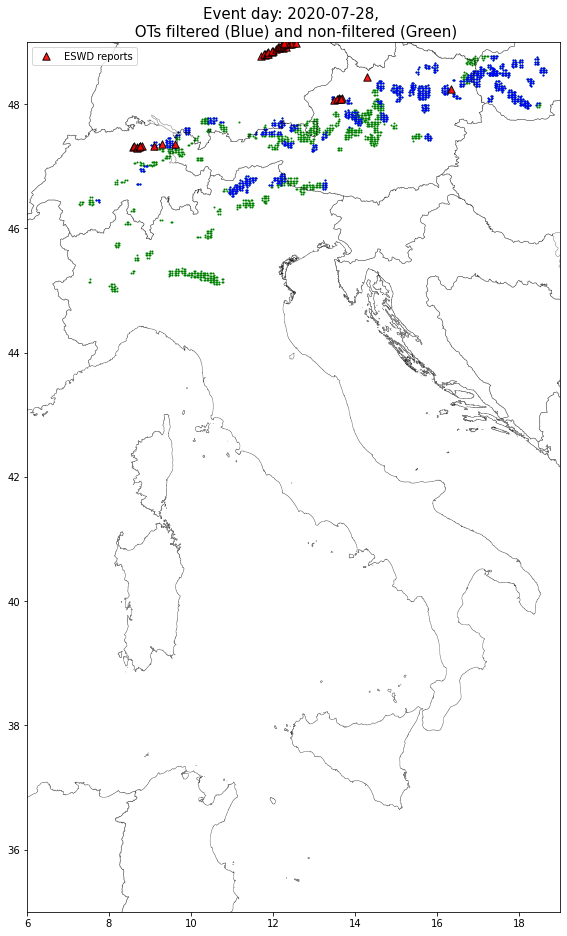

In [142]:
fig, ax = plt.subplots(figsize = (20,16))
latplot=[latmin,latmax]; lonplot=[lonmin,lonmax]
x_lim=lonplot
y_lim=latplot
plt.xlim(x_lim)
plt.ylim(y_lim) #y_lim

#filtered and non-filtered OTs detections    
for hour in orig_OT.keys():
    orig_OT[hour][['otpmax','geometry']].plot(ax=ax, markersize=1, figsize=(12, 8), column='otpmax', 
                                              color='green', zorder=1)
    if len(filt_OT[hour]) != 0:
        filt_OT[hour][['otpmax','geometry']].plot(ax=ax, markersize=1, figsize=(12, 8), column='otpmax', 
                                                  color='blue', zorder=2)
#shapefiles    
for shp in sf_geo:
    shp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)

#eswd 
if len(eswd_ev_sel) != 0:
    pl.scatter(eswd_ev_sel.lon,eswd_ev_sel.lat,55,c='red',marker="^",edgecolor='k',alpha=0.9,zorder=4, 
           label='ESWD reports')

plt.legend(loc='best')

plt.title(f'Event day: {dtime.year}-{dtime.month:02d}-{dtime.day:02d}, \n OTs filtered (Blue) and non-filtered (Green)',
         fontsize=15);
#pl.savefig(f"/home/ciccuz/phd/KIT/scripts/plots_2019-2020/single_events_plots/{dtime.year}/{dtime}.png",dpi=200, bbox_inches='tight')